## Preprocessing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Dissertation/modified liif/datasets/IXI-T2-MidSlices')

In [ ]:
import os
import gzip
import shutil
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define directories
input_dir = 'IXI-T2-MidSlices'
output_dir = 'IXI-T2-MidSlices'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create output directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all .gz files in the input directory
gz_files = [f for f in os.listdir(input_dir) if f.endswith('.gz')]

# Function to extract a slice from a .nii file and save it as an image
def save_slice(nifti_path, save_path):
    # Load the .nii file
    img = nib.load(nifti_path)
    img_data = img.get_fdata()

    # Get the middle slice (along the third axis)
    middle_slice = img_data[:, :, img_data.shape[2] // 2]

    # Display the dimensions
    print(f"Dimensions of the slice: {middle_slice.shape}")

    # Save the slice as an image
    plt.imsave(save_path, middle_slice, cmap='gray')

# Extract .nii files from .gz and save one slice as an image
extracted_images = []
for gz_file in gz_files:
    gz_path = os.path.join(input_dir, gz_file)
    nii_filename = gz_file.replace('.gz', '.nii')
    nii_path = os.path.join(input_dir, nii_filename)

    # Extract the .nii file
    with gzip.open(gz_path, 'rb') as f_in:
        with open(nii_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Define the save path for the image
    img_filename = nii_filename.replace('.nii', '.png')
    img_save_path = os.path.join(output_dir, img_filename)

    # Save one slice from the .nii file as an image
    save_slice(nii_path, img_save_path)

    # Collect the image path for dataset splitting
    extracted_images.append(img_save_path)

    # Remove the extracted .nii file to save space
    os.remove(nii_path)

# Split the dataset
train_images, temp_images = train_test_split(extracted_images, train_size=500, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=70, random_state=42)

# Function to move images to respective directories
def move_images(image_list, target_dir):
    for img_path in image_list:
        shutil.move(img_path, os.path.join(target_dir, os.path.basename(img_path)))

# Move images to train, validation, and test directories
move_images(train_images, train_dir)
move_images(val_images, val_dir)
move_images(test_images, test_dir)

print("Dataset prepared successfully!")

In [ ]:
import os
import cv2
from scipy.ndimage import gaussian_filter
from PIL import Image
import numpy as np

# Define the input and output directories
input_dir = 'test'  # Update this path to your source folder
output_dir = 'test x4'  # Update this path to your destination folder

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to resize an image using Method 1 (Gaussian blur + down-sampling)
def resize_image(input_path, output_path, size=(64, 64), sigma=1):
    # Load the image using PIL and convert to grayscale
    with Image.open(input_path) as img:
        img = img.convert('L')  # Convert to grayscale

        # Convert the image to a NumPy array
        img_np = np.array(img, dtype=np.float32)

        # Apply Gaussian blur
        blurred_img = gaussian_filter(img_np, sigma=sigma)

        # Down-sample the image using cv2.INTER_AREA
        resized_img = cv2.resize(blurred_img, size, interpolation=cv2.INTER_AREA)

        # Convert back to PIL image
        resized_img_pil = Image.fromarray(np.uint8(resized_img))

        # Save the resized image to the output directory
        resized_img_pil.save(output_path)

# Loop through all images in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.png'):  # Assuming the images are in PNG format
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        # Resize and save the image using [Gaussian blur + down-sampling]
        resize_image(input_path, output_path)

print("All images have been resized using [Gaussian blur + down-sampling] and saved to the output directory.")

All images have been resized using [Gaussian blur + down-sampling] and saved to the output directory.


##  ELTRV Implementation

#### 4x LR Main

Super-resolved image saved at ./results/IXI160-HH-1637-T2_bicubic4x_upscaled_image.png


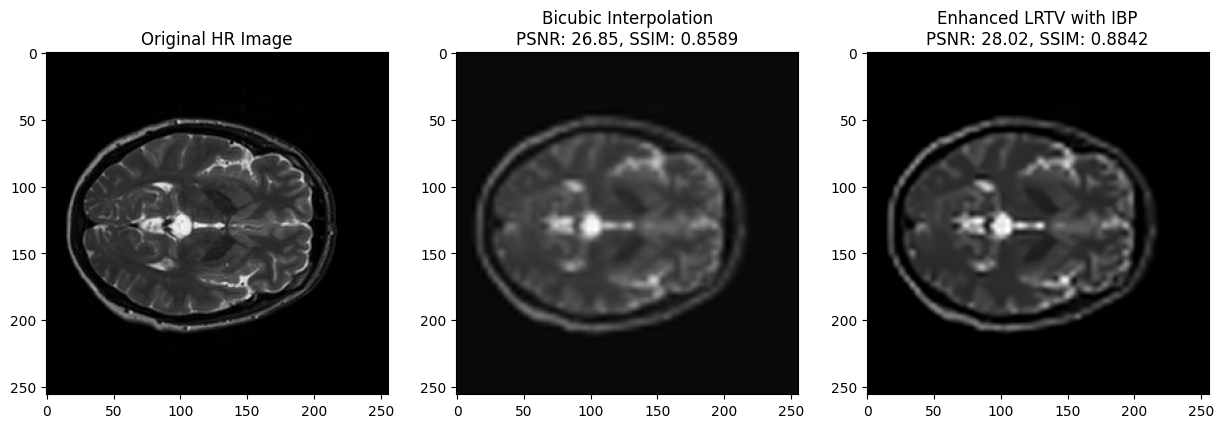

Super-resolved image saved at ./results/IXI160-HH-1637-T2_elrtv_x4.png


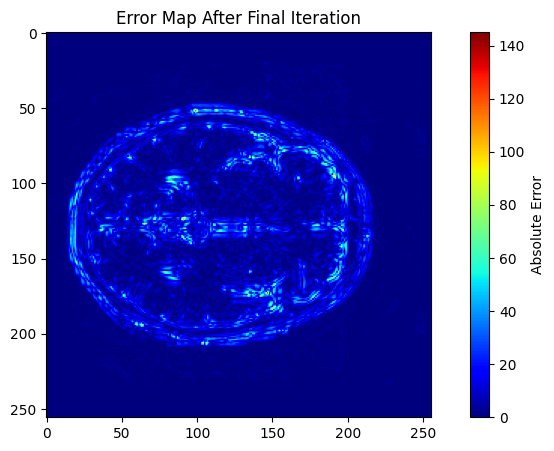

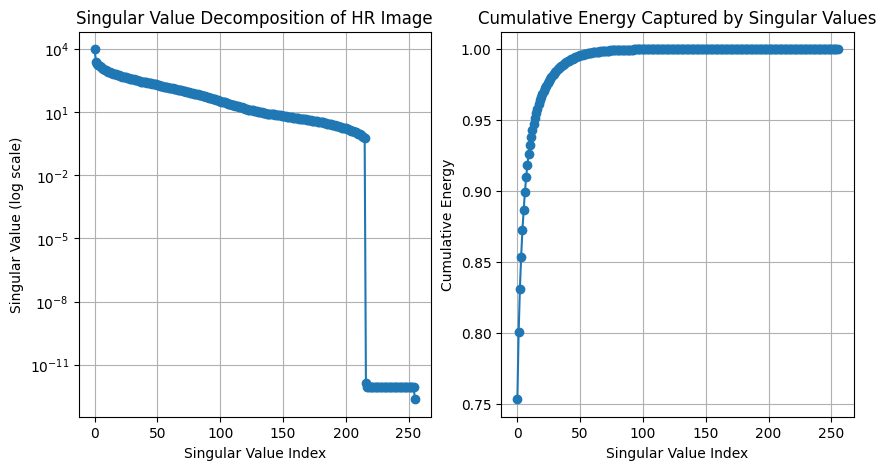

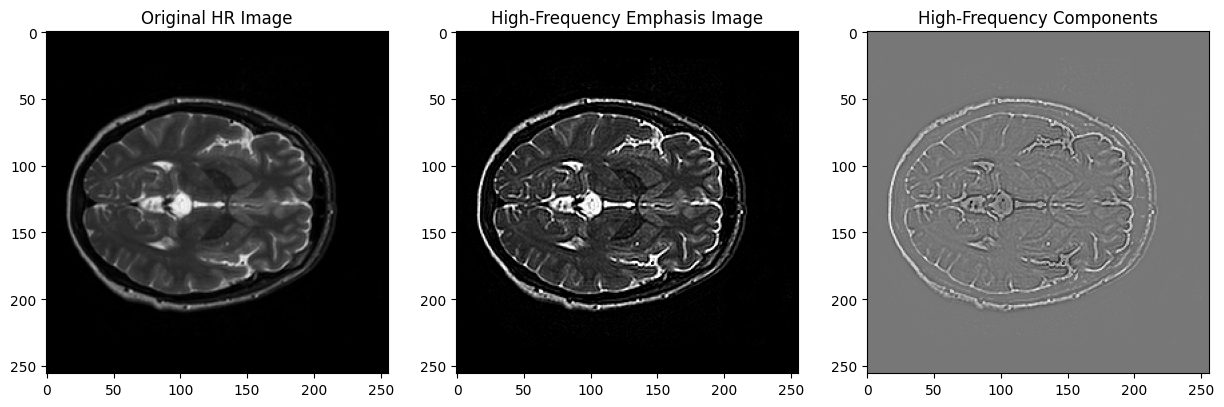

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# Adjustable Parameters
weight_bicubic = 0.6622607894886021  # Weight for bicubic upsampling in the combined method
weight_lanczos = 1 - weight_bicubic  # Complementary weight for Lanczos upsampling
max_iter = 1511  # Number of iterations for the ADMM loop
lambda_tv_base = 1.733327535786038e-11  # Base value for Total Variation regularization
lambda_rank_base = 2.3717622528337845e-11  # Base value for Low-Rank Approximation
rho = 0.6569306514552269  # ADMM parameter controlling Lagrange multiplier update
learning_rate = 9.347759642251841e-10  # Step size for gradient descent
l1_weight = 0.64534999999946  # Balance between L1 and L2 norms in data fidelity
ibp_iter = 939  # Number of iterations for Iterative Back-Projection
projection_alpha = 0.8770544660411966  # Weight for the projection step in IBP
alpha_high_freq = 3.7145763292614973  # Weight for high-frequency emphasis
h_nlm = 1.9734299742528338  # Initial strength of Non-Local Means filtering
adaptive_noise = True  # Whether to use adaptive noise filtering
noise_scale = 0.22474859515903967  # Scale factor for adaptive noise filtering
anti_aliasing_sigma = 0.3297621519967887  # Sigma value for anti-aliasing filter
adaptive_lambda_tv_strength = 0.863370508885509  # Strength for adaptive TV regularization
adaptive_lambda_rank_strength = 0.9904711310449325  # Strength for adaptive rank regularization
upscaling_steps = 2  # Number of steps for gradual upscaling
target_scale_factor = 4  # Updated for 4x scaling (64x64 to 256x256)

# Parameters for adaptive regularization
adaptive_lambda_tv_strength = 0.5  # Controls how much lambda_tv adapts
adaptive_lambda_rank_strength = 0.5  # Controls how much lambda_rank adapts

# Load and preprocess images
def load_and_preprocess_images(hr_path):
    hr_img = cv2.imread(hr_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    hr_img = cv2.resize(hr_img, (256, 256))  # Ensure HR image is 256x256

    # Generate LR image by blurring and down-sampling the HR image
    blurred_hr = gaussian_filter(hr_img, sigma=1)
    lr_img = cv2.resize(blurred_hr, (64, 64), interpolation=cv2.INTER_AREA)  # Down-sample to 64x64

    return hr_img, lr_img

# Bicubic upsampling (Baseline)
def bicubic_upsample(lr_img, scale_factor=4):
    new_size = (int(lr_img.shape[1] * scale_factor), int(lr_img.shape[0] * scale_factor))
    return cv2.resize(lr_img, new_size, interpolation=cv2.INTER_CUBIC)

# Combined Bicubic and Lanczos upsampling with weights
def combined_upsample(lr_img, scale_factor=4, weight_bicubic=0.3, weight_lanczos=0.7):
    bicubic_img = bicubic_upsample(lr_img, scale_factor)
    lanczos_img = cv2.resize(lr_img, (bicubic_img.shape[1], bicubic_img.shape[0]), interpolation=cv2.INTER_LANCZOS4)
    combined_img = weight_bicubic * bicubic_img + (1 - weight_bicubic) * lanczos_img
    return combined_img

# High-Frequency Emphasis to Preserve Details
def high_frequency_emphasis(img, alpha=0.5874342365346249):
    blurred = gaussian_filter(img, sigma=1)
    high_freq = img - blurred
    enhanced = img + alpha * high_freq
    return np.clip(enhanced, 0, 255)

# Adaptive Non-Local Means Regularization
def adaptive_non_local_means(img, base_h=1.0, adaptive=True, scale=1.0):
    if adaptive:
        sigma_est = np.mean(cv2.fastNlMeansDenoising(img.astype(np.uint8), None, base_h, 7, 21))
        h = max(scale * sigma_est, 0.1)
    else:
        h = base_h
    return cv2.fastNlMeansDenoising(img.astype(np.uint8), None, h, 7, 21).astype(np.float32)

# Singular Value Thresholding (SVT) for Low-Rank Approximation
def svt(X, tau):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S = np.maximum(S - tau, 0)
    return np.dot(U, np.dot(np.diag(S), Vt))

# Anisotropic Total Variation Regularization
def anisotropic_tv(X, lambda_tv):
    grad_x = np.diff(X, axis=1)
    grad_y = np.diff(X, axis=0)
    grad_x = np.pad(grad_x, ((0, 0), (0, 1)), mode='constant')
    grad_y = np.pad(grad_y, ((0, 1), (0, 0)), mode='constant')
    norm_x = np.abs(grad_x)
    norm_y = np.abs(grad_y)
    X = X.copy()
    X[:, :-1] -= lambda_tv * grad_x[:, :-1] / np.maximum(norm_x[:, :-1], 1e-10)
    X[:-1, :] -= lambda_tv * grad_y[:-1, :] / np.maximum(norm_y[:-1, :], 1e-10)
    return X

# Gradient for data fidelity term with hybrid L1 and L2 norms
def compute_hybrid_gradient(hr_img, lr_img, l1_weight=0.5919442711660051):
    blurred_hr = gaussian_filter(hr_img, sigma=1)
    downsampled_hr = cv2.resize(blurred_hr, (lr_img.shape[1], lr_img.shape[0]), interpolation=cv2.INTER_LINEAR)
    diff = downsampled_hr - lr_img
    l1_grad = np.sign(diff)
    l2_grad = diff
    grad = l1_weight * l1_grad + (1 - l1_weight) * l2_grad
    grad = cv2.resize(grad, (hr_img.shape[1], hr_img.shape[0]), interpolation=cv2.INTER_LINEAR)
    return grad

# Adaptive lambda regularization
def adapt_lambda(base_value, image, strength):
    variance = np.var(image)
    return base_value * (1 + strength * variance)

# Iterative Back-Projection (IBP)
def iterative_back_projection(sr_img, lr_img, max_iter=10, projection_alpha=0.2):
    for _ in range(max_iter):
        downsampled_sr = cv2.resize(sr_img, (lr_img.shape[1], lr_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        diff = lr_img - downsampled_sr
        diff_upscaled = cv2.resize(diff, (sr_img.shape[1], sr_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        sr_img += projection_alpha * diff_upscaled
    return sr_img

# Anti-Aliasing filter (Gaussian Blur)
def apply_anti_aliasing(img, sigma=0.5):
    return gaussian_filter(img, sigma=sigma)

# Gradual Upscaling with Anti-Aliasing
def gradual_upscaling(lr_img, target_scale_factor, steps=2, anti_aliasing_sigma=0.5):
    current_img = lr_img
    scale_step = target_scale_factor ** (1.0 / steps)
    for _ in range(steps):
        current_img = apply_anti_aliasing(current_img, sigma=anti_aliasing_sigma)
        current_img = combined_upsample(current_img, scale_factor=scale_step)
    return current_img

# LRTV super-resolution using ADMM with Enhanced Regularization and IBP
def admm_lrtv_with_ibp(lr_img, target_scale_factor, weight_bicubic, weight_lanczos, max_iter, lambda_tv_base, lambda_rank_base, rho, learning_rate, l1_weight, ibp_iter, projection_alpha, upscaling_steps=2, anti_aliasing_sigma=0.5, alpha_high_freq=0.2, h_nlm=1, noise_scale=0.05, adaptive_lambda_tv_strength=0.5, adaptive_lambda_rank_strength=0.5):
    hr_img = gradual_upscaling(lr_img, target_scale_factor=target_scale_factor, steps=upscaling_steps, anti_aliasing_sigma=anti_aliasing_sigma)
    hr_img = cv2.resize(hr_img, (256, 256))  # Ensure final image is 256x256

    M = hr_img.copy()
    Y = np.zeros_like(hr_img)

    for i in range(max_iter):
        # Adapt lambda values based on image content
        lambda_tv = adapt_lambda(lambda_tv_base, hr_img, adaptive_lambda_tv_strength)
        lambda_rank = adapt_lambda(lambda_rank_base, hr_img, adaptive_lambda_rank_strength)

        # Compute hybrid gradient for data fidelity
        grad = compute_hybrid_gradient(hr_img, lr_img, l1_weight=l1_weight)
        hr_img -= learning_rate * (grad + rho * (hr_img - M + Y))

        # Apply Singular Value Thresholding for low-rank approximation
        M = svt(hr_img + Y, lambda_rank / rho)

        # Update Lagrange multiplier
        Y += hr_img - M

        # Apply Anisotropic TV Regularization
        hr_img = anisotropic_tv(hr_img, lambda_tv=lambda_tv)

    # Apply Iterative Back-Projection (IBP)
    hr_img = iterative_back_projection(hr_img, lr_img, max_iter=ibp_iter, projection_alpha=projection_alpha)

    # Apply high-frequency emphasis to enhance details
    hr_img = high_frequency_emphasis(hr_img, alpha=alpha_high_freq)

    # Apply adaptive Non-Local Means filtering
    hr_img = adaptive_non_local_means(hr_img, base_h=h_nlm, adaptive=adaptive_noise, scale=noise_scale)

    return cv2.resize(hr_img, (256, 256))  # Ensures final image is 256x256

# Error Map Visualization
def plot_error_map(hr_img, sr_img):
    error_map = np.abs(hr_img - sr_img)
    plt.figure(figsize=(10, 5))
    plt.imshow(error_map, cmap='jet')
    plt.title('Error Map After Final Iteration')
    plt.colorbar(label='Absolute Error')
    plt.show()

# Singular Value Decomposition (SVD) Plot
def plot_svd(hr_img):
    U, S, Vt = np.linalg.svd(hr_img, full_matrices=False)

    # Plot singular values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(S, 'o-')
    plt.yscale('log')
    plt.title('Singular Value Decomposition of HR Image')
    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value (log scale)')
    plt.grid(True)

    # Plot cumulative sum of singular values
    plt.subplot(1, 2, 2)
    cumulative_energy = np.cumsum(S**2) / np.sum(S**2)
    plt.plot(cumulative_energy, 'o-')
    plt.title('Cumulative Energy Captured by Singular Values')
    plt.xlabel('Singular Value Index')
    plt.ylabel('Cumulative Energy')
    plt.grid(True)
    plt.show()

# High-Frequency Component Emphasis Visualization
def plot_high_frequency_emphasis(hr_img):
    enhanced_img = high_frequency_emphasis(hr_img, alpha=alpha_high_freq)
    high_freq_component = enhanced_img - hr_img

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(hr_img, cmap='gray')
    plt.title('Original HR Image')

    plt.subplot(1, 3, 2)
    plt.imshow(enhanced_img, cmap='gray')
    plt.title('High-Frequency Emphasis Image')

    plt.subplot(1, 3, 3)
    plt.imshow(high_freq_component, cmap='gray')
    plt.title('High-Frequency Components')

    plt.show()

# Save SR image to specified path
def save_sr_image(sr_img, path):
    sr_img_uint8 = np.clip(sr_img, 0, 255).astype(np.uint8)
    cv2.imwrite(path, sr_img_uint8)
    print(f"Super-resolved image saved at {path}")

# Evaluate and display results
def display_results(hr_img, lr_img, sr_img):
    bicubic_img = bicubic_upsample(lr_img, scale_factor=4)  # Updated to 4x

    # Save Bicubic upsampled image to specified path
    bicubic_output_path = './results/IXI160-HH-1637-T2_bicubic4x_upscaled_image.png'
    save_sr_image(bicubic_img, bicubic_output_path)

    sr_img_resized = np.clip(sr_img, 0, 255)
    hr_img = np.clip(hr_img, 0, 255)

    data_range = 255
    psnr_bicubic = psnr(hr_img, bicubic_img, data_range=data_range)
    psnr_sr = psnr(hr_img, sr_img_resized, data_range=data_range)
    ssim_bicubic = ssim(hr_img, bicubic_img, data_range=data_range)
    ssim_sr = ssim(hr_img, sr_img_resized, data_range=data_range)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(hr_img, cmap='gray')
    plt.title('Original HR Image')

    plt.subplot(1, 3, 2)
    plt.imshow(bicubic_img, cmap='gray')
    plt.title(f'Bicubic Interpolation\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}')

    plt.subplot(1, 3, 3)
    plt.imshow(sr_img_resized, cmap='gray')
    plt.title(f'Enhanced LRTV with IBP\nPSNR: {psnr_sr:.2f}, SSIM: {ssim_sr:.4f}')

    plt.show()

# Paths to the images
hr_img_path = './datasets/IXI-T2-Images/test/IXI160-HH-1637-T2.png'

# Load and preprocess images
hr_img, lr_img = load_and_preprocess_images(hr_img_path)

# Perform ADMM LRTV super-resolution with Enhanced Regularization and IBP
sr_img = admm_lrtv_with_ibp(
    lr_img,
    target_scale_factor=target_scale_factor,
    weight_bicubic=weight_bicubic,
    weight_lanczos=weight_lanczos,
    max_iter=max_iter,
    lambda_tv_base=lambda_tv_base,
    lambda_rank_base=lambda_rank_base,
    rho=rho,
    learning_rate=learning_rate,
    l1_weight=l1_weight,
    ibp_iter=ibp_iter,
    projection_alpha=projection_alpha,
    upscaling_steps=upscaling_steps,
    anti_aliasing_sigma=anti_aliasing_sigma,
    alpha_high_freq=alpha_high_freq,
    h_nlm=h_nlm,
    noise_scale=noise_scale,
    adaptive_lambda_tv_strength=adaptive_lambda_tv_strength,
    adaptive_lambda_rank_strength=adaptive_lambda_rank_strength
)

# Display and evaluate results
display_results(hr_img, lr_img, sr_img)

# Save the super-resolved image
output_path = './results/IXI160-HH-1637-T2_elrtv_x4.png'  # Save path for the SR image
save_sr_image(sr_img, output_path)

# Additional plots for analysis
plot_error_map(hr_img, sr_img)
plot_svd(hr_img)
plot_high_frequency_emphasis(hr_img)

#### 4x LR Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler
import cv2
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import pickle

# Load images and preprocess to generate low-resolution images
def load_images(hr_dir, num_images=25):
    hr_images = []
    lr_images = []

    hr_files = sorted(os.listdir(hr_dir))[:num_images]

    for hr_file in hr_files:
        hr_img = cv2.imread(os.path.join(hr_dir, hr_file), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        hr_img = cv2.resize(hr_img, (256, 256))  # Ensure HR image is 256x256

        # Generate LR image by blurring and down-sampling the HR image
        blurred_hr = gaussian_filter(hr_img, sigma=1)  # Gaussian blur with standard deviation of 1 voxel
        lr_img = cv2.resize(blurred_hr, (64, 64), interpolation=cv2.INTER_AREA)  # Down-sample to 64x64

        hr_images.append(hr_img)
        lr_images.append(lr_img)

    return hr_images, lr_images

# Objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space with updated ranges for 4x task
    weight_bicubic = trial.suggest_float('weight_bicubic', 0.1, 0.7)
    weight_lanczos = 1 - weight_bicubic
    max_iter = trial.suggest_int('max_iter', 500, 2000)  # Increased upper limit for better convergence
    lambda_tv_base = trial.suggest_float('lambda_tv_base', 1e-9, 1e-6, log=True)
    lambda_rank_base = trial.suggest_float('lambda_rank_base', 1e-9, 1e-6, log=True)
    rho = trial.suggest_float('rho', 0.01, 2.0, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1e-5, log=True)
    l1_weight = trial.suggest_float('l1_weight', 0.1, 0.9)
    ibp_iter = trial.suggest_int('ibp_iter', 100, 1000)  # Increased upper limit for more IBP iterations
    projection_alpha = trial.suggest_float('projection_alpha', 0.1, 0.7)
    alpha_high_freq = trial.suggest_float('alpha_high_freq', 0.5, 3.0)  # Increased upper limit to enhance detail
    h_nlm = trial.suggest_float('h_nlm', 0.5, 3.0)
    noise_scale = trial.suggest_float('noise_scale', 0.01, 0.3)
    anti_aliasing_sigma = trial.suggest_float('anti_aliasing_sigma', 0.1, 1.0)
    upscaling_steps = 2
    adaptive_lambda_tv_strength = trial.suggest_float('adaptive_lambda_tv_strength', 0.1, 1.0)
    adaptive_lambda_rank_strength = trial.suggest_float('adaptive_lambda_rank_strength', 0.1, 1.0)

    # Load the first 25 images
    hr_images, lr_images = load_images('./datasets/IXI-T2-Images/train', num_images=15)

    total_psnr = 0
    total_ssim = 0
    for hr_img, lr_img in zip(hr_images, lr_images):
        # Perform ADMM LRTV super-resolution with the suggested hyperparameters
        sr_img = admm_lrtv_with_ibp(
            lr_img,
            target_scale_factor=4,  # Final scaling factor (64x64 to 256x256)
            weight_bicubic=weight_bicubic,
            weight_lanczos=weight_lanczos,
            max_iter=max_iter,
            lambda_tv_base=lambda_tv_base,
            lambda_rank_base=lambda_rank_base,
            rho=rho,
            learning_rate=learning_rate,
            l1_weight=l1_weight,
            ibp_iter=ibp_iter,
            projection_alpha=projection_alpha,
            alpha_high_freq=alpha_high_freq,
            h_nlm=h_nlm,
            noise_scale=noise_scale,
            anti_aliasing_sigma=anti_aliasing_sigma,
            upscaling_steps=upscaling_steps,
            adaptive_lambda_tv_strength=adaptive_lambda_tv_strength,
            adaptive_lambda_rank_strength=adaptive_lambda_rank_strength
        )

        # Calculate PSNR and SSIM for this image
        psnr_value = psnr(hr_img, sr_img, data_range=255)
        ssim_value = ssim(hr_img, sr_img, data_range=255)

        total_psnr += psnr_value
        total_ssim += ssim_value

    # Return the average PSNR and SSIM over all images
    avg_psnr = total_psnr / len(hr_images)
    avg_ssim = total_ssim / len(hr_images)

    # Print PSNR and SSIM for this trial
    print(f'Trial {trial.number}: PSNR={avg_psnr:.4f}, SSIM={avg_ssim:.4f}')

    # Combine PSNR and SSIM into a single metric with 70% weight on SSIM and 30% on PSNR
    combined_metric = 0.3 * avg_psnr + 0.7 * avg_ssim

    return combined_metric

# Function to save the study
def save_study(study, filename):
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

# Function to load the study
def load_study(filename):
    with open(filename, 'rb') as f:
        study = pickle.load(f)
    return study

# Define study filename
study_filename = 'lrtv_4x_optuna_study.pkl'

# Check if a study file exists, if so, load it; otherwise, create a new study
if os.path.exists(study_filename):
    study = load_study(study_filename)
else:
    study = optuna.create_study(direction='maximize', sampler=TPESampler())

# Run Optuna optimization with progress bar
try:
    study.optimize(objective, n_trials=100, callbacks=[lambda study, trial: save_study(study, study_filename)], show_progress_bar=True)
except KeyboardInterrupt:
    print("Optimization interrupted. Study saved.")

# Display the best parameters and the best combined metric value
print("Best Combined Metric (Weighted PSNR + SSIM): ", study.best_value)
print("Best parameters: ", study.best_params)

[I 2024-08-17 14:25:21,648] A new study created in memory with name: no-name-4c8eff43-17fb-434d-8ca8-bfd8d571b968


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0: PSNR=26.1643, SSIM=0.8300
[I 2024-08-17 14:28:17,583] Trial 0 finished with value: 8.430284987824125 and parameters: {'weight_bicubic': 0.6881286783722247, 'max_iter': 598, 'lambda_tv_base': 3.9648225259270414e-08, 'lambda_rank_base': 2.8711231321012753e-09, 'rho': 0.18026101510487808, 'learning_rate': 1.7687039076954595e-08, 'l1_weight': 0.3665969085496569, 'ibp_iter': 232, 'projection_alpha': 0.5896580180953366, 'alpha_high_freq': 0.61886315608583, 'h_nlm': 0.8425396185362684, 'noise_scale': 0.11034427239263092, 'anti_aliasing_sigma': 0.32258160562231586, 'adaptive_lambda_tv_strength': 0.23009829105620402, 'adaptive_lambda_rank_strength': 0.45825345236278425}. Best is trial 0 with value: 8.430284987824125.
Trial 1: PSNR=25.9773, SSIM=0.8163
[I 2024-08-17 14:35:20,160] Trial 1 finished with value: 8.364562593996606 and parameters: {'weight_bicubic': 0.588361550621491, 'max_iter': 1415, 'lambda_tv_base': 7.50702226228846e-08, 'lambda_rank_base': 7.654159538546524e-09, 'rho': 0

#### 4x LR Eval

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize variables to store cumulative PSNR and SSIM values
total_bicubic_psnr = 0
total_sr_psnr = 0
total_bicubic_ssim = 0
total_sr_ssim = 0
total_nn_psnr = 0
num_images = 0

# Variables to store the top 5 PSNR and SSIM results
top_psnr_results = []
top_ssim_results = []

# Get list of images in the directory
image_files = [f for f in os.listdir('./datasets/IXI-T2-Images/test') if f.endswith('.png')]

# Iterate through each image
for image_file in tqdm(image_files, desc="Evaluating images"):
    # Load and preprocess the current image
    hr_img_path = os.path.join('./datasets/IXI-T2-Images/test', image_file)
    hr_img, lr_img = load_and_preprocess_images(hr_img_path)

    # Perform super-resolution
    sr_img = admm_lrtv_with_ibp(
        lr_img,
        target_scale_factor=target_scale_factor,
        weight_bicubic=weight_bicubic,
        weight_lanczos=weight_lanczos,
        max_iter=max_iter,
        lambda_tv_base=lambda_tv_base,
        lambda_rank_base=lambda_rank_base,
        rho=rho,
        learning_rate=learning_rate,
        l1_weight=l1_weight,
        ibp_iter=ibp_iter,
        projection_alpha=projection_alpha,
        upscaling_steps=upscaling_steps,
        anti_aliasing_sigma=anti_aliasing_sigma,
        alpha_high_freq=alpha_high_freq,
        h_nlm=h_nlm,
        noise_scale=noise_scale,
        adaptive_lambda_tv_strength=adaptive_lambda_tv_strength,
        adaptive_lambda_rank_strength=adaptive_lambda_rank_strength
    )

    # Calculate PSNR and SSIM for nearest neighbor upsampling
    nn_img = cv2.resize(lr_img, (256, 256), interpolation=cv2.INTER_NEAREST)
    psnr_nn = psnr(hr_img, nn_img, data_range=255)

    # Calculate PSNR and SSIM for bicubic upsampling
    bicubic_img = bicubic_upsample(lr_img, scale_factor=4)
    psnr_bicubic = psnr(hr_img, bicubic_img, data_range=255)
    ssim_bicubic = ssim(hr_img, bicubic_img, data_range=255)

    # Calculate PSNR and SSIM for super-resolution
    sr_img_resized = np.clip(sr_img, 0, 255)
    psnr_sr = psnr(hr_img, sr_img_resized, data_range=255)
    ssim_sr = ssim(hr_img, sr_img_resized, data_range=255)

    # Accumulate PSNR and SSIM values
    total_nn_psnr += psnr_nn
    total_bicubic_psnr += psnr_bicubic
    total_sr_psnr += psnr_sr
    total_bicubic_ssim += ssim_bicubic
    total_sr_ssim += ssim_sr
    num_images += 1

    # Track the top 5 PSNR and SSIM
    top_psnr_results.append((psnr_sr, hr_img, nn_img, bicubic_img, sr_img_resized, psnr_bicubic, ssim_bicubic, psnr_nn))
    top_ssim_results.append((ssim_sr, hr_img, nn_img, bicubic_img, sr_img_resized, psnr_bicubic, ssim_bicubic, psnr_nn))

    # Sort and keep the top 5
    top_psnr_results = sorted(top_psnr_results, key=lambda x: x[0], reverse=True)[:5]
    top_ssim_results = sorted(top_ssim_results, key=lambda x: x[0], reverse=True)[:5]

# Calculate average PSNR and SSIM
average_nn_psnr = total_nn_psnr / num_images
average_bicubic_psnr = total_bicubic_psnr / num_images
average_sr_psnr = total_sr_psnr / num_images
average_bicubic_ssim = total_bicubic_ssim / num_images
average_sr_ssim = total_sr_ssim / num_images

Evaluating images: 100%|██████████| 70/70 [46:29<00:00, 39.85s/it]


Average Nearest Neighbor PSNR: 24.82
Average Bicubic PSNR: 25.88
Average Super-Resolution PSNR: 26.89
Average Bicubic SSIM: 0.8248
Average Super-Resolution SSIM: 0.8504


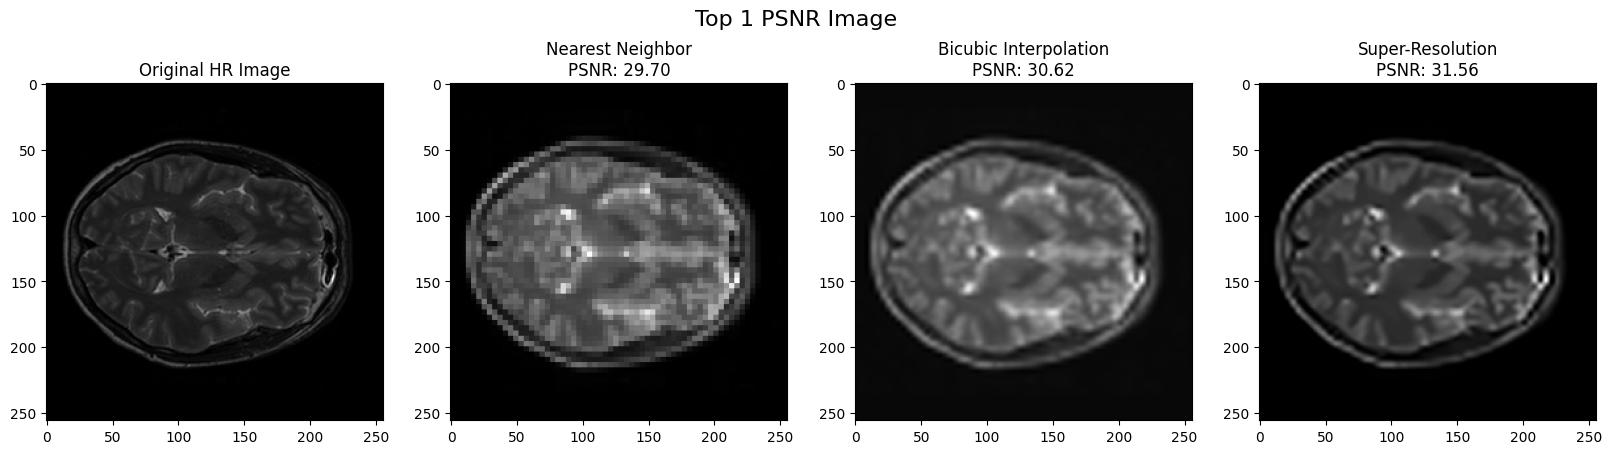

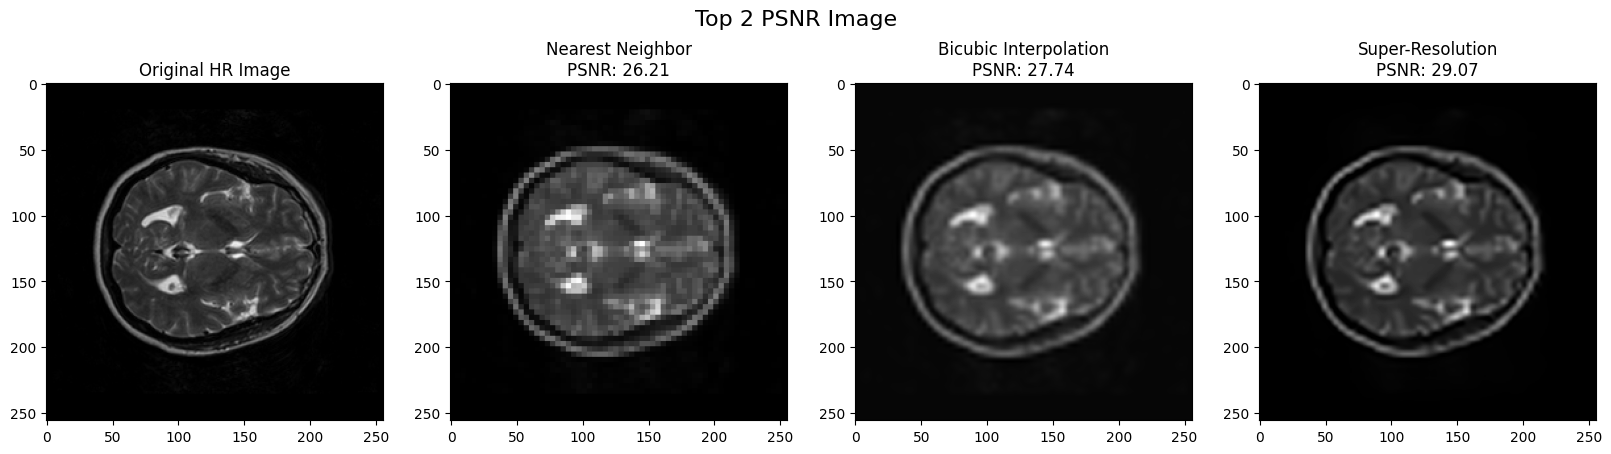

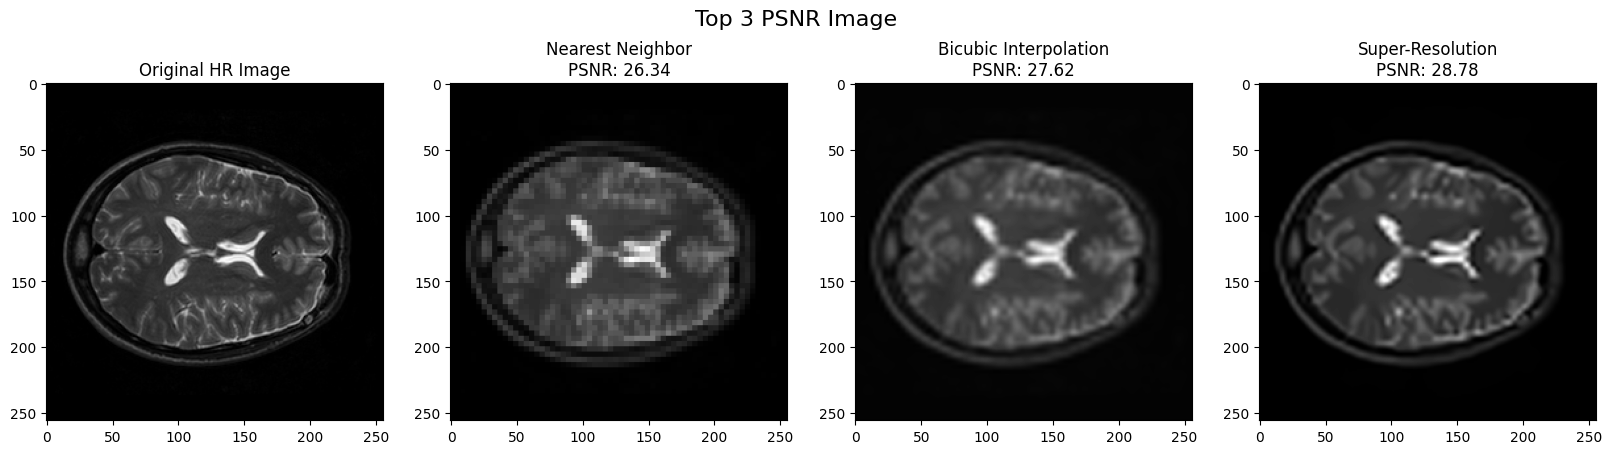

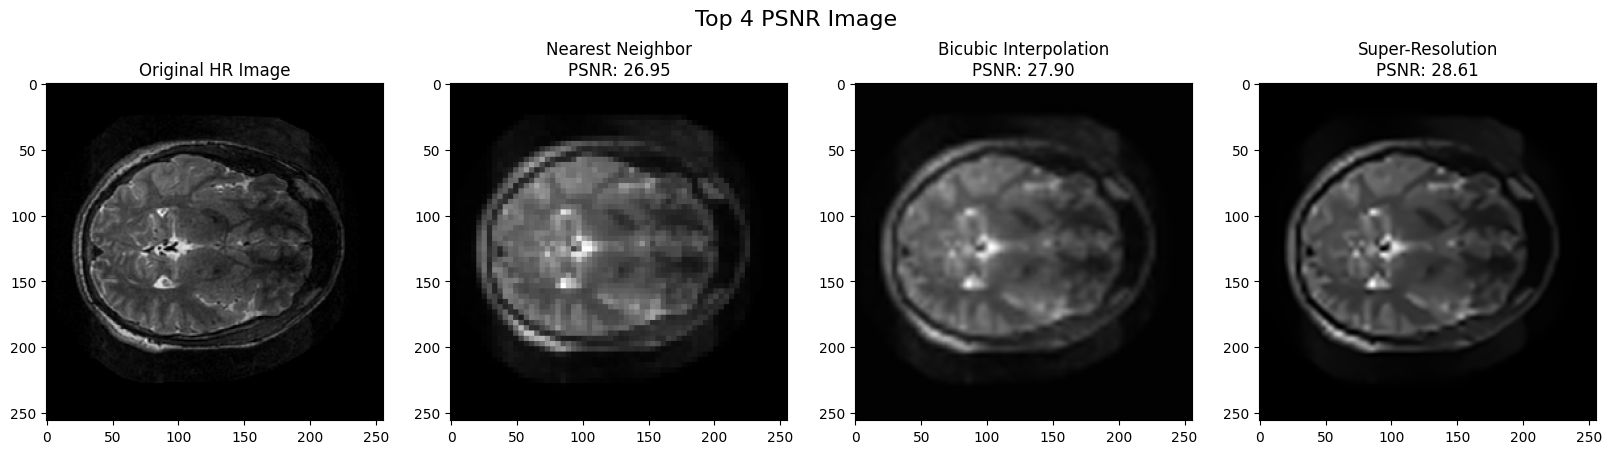

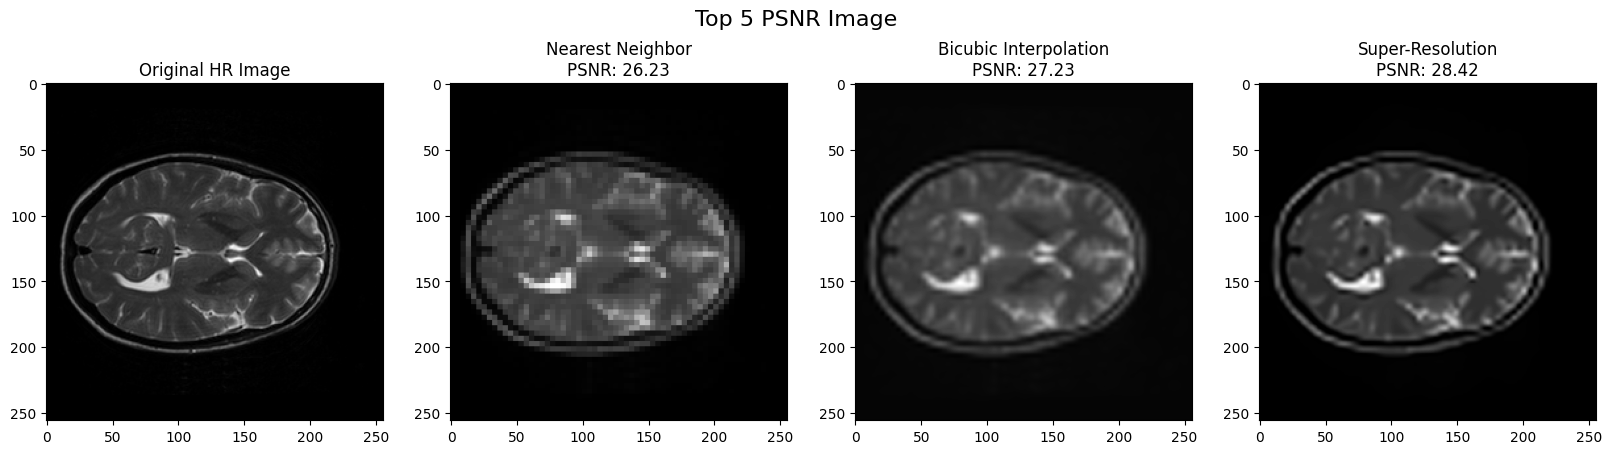

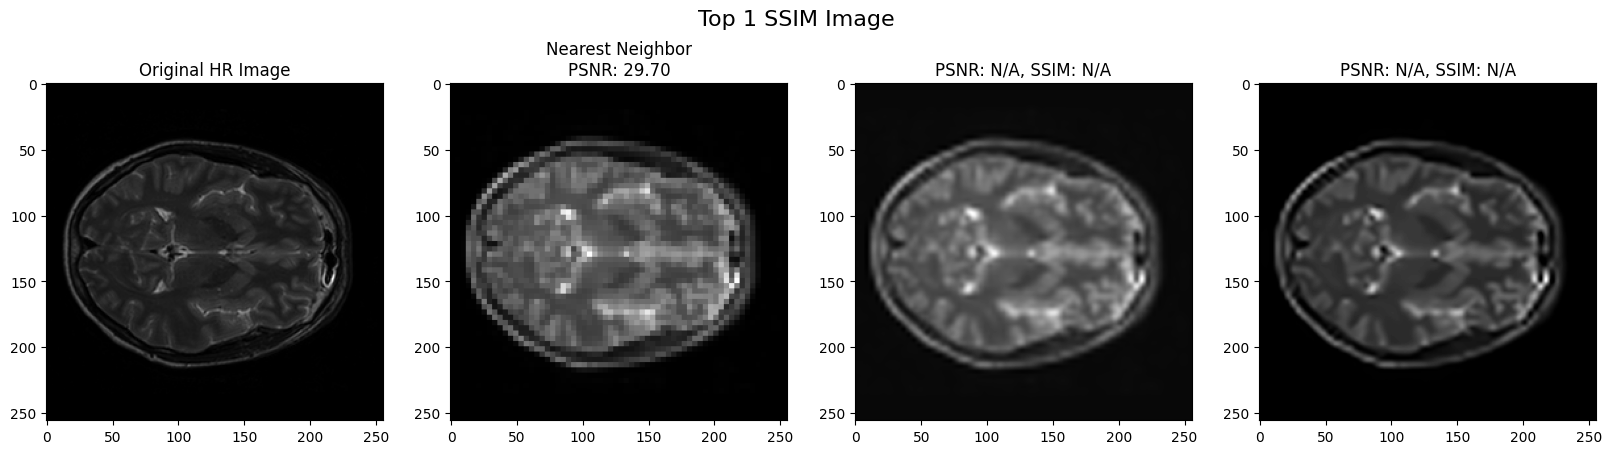

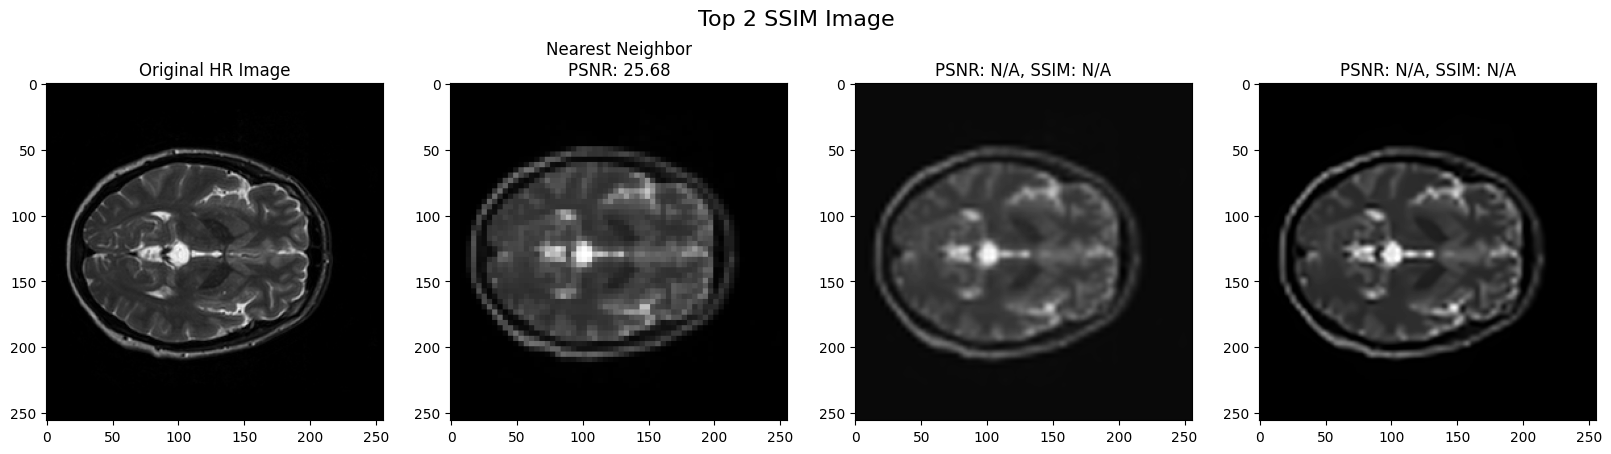

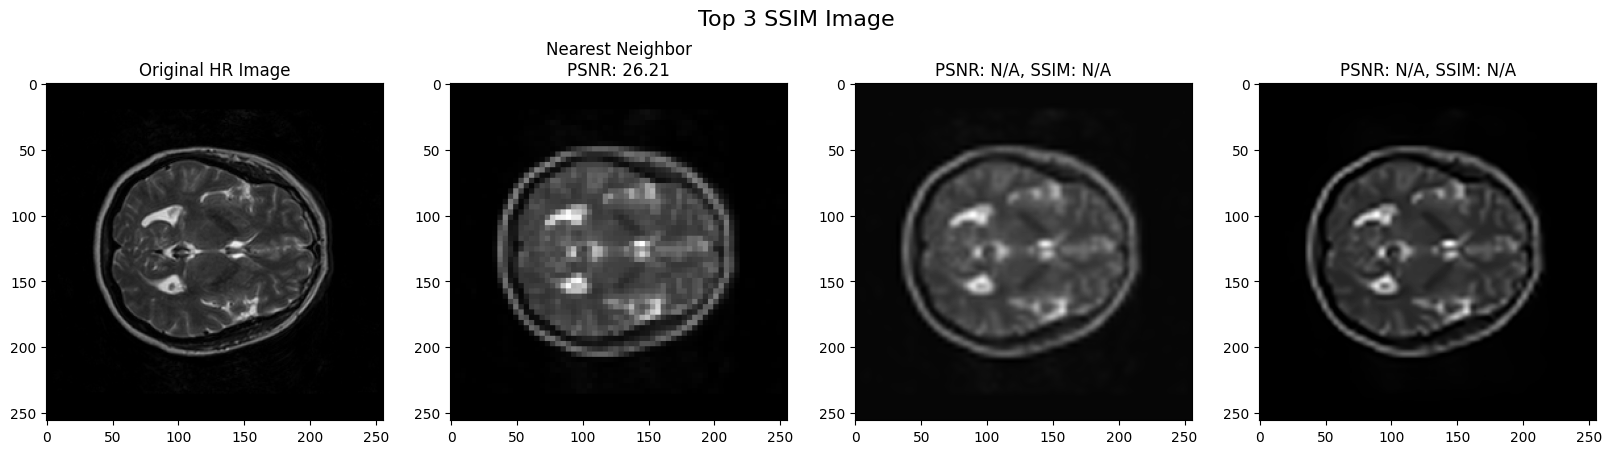

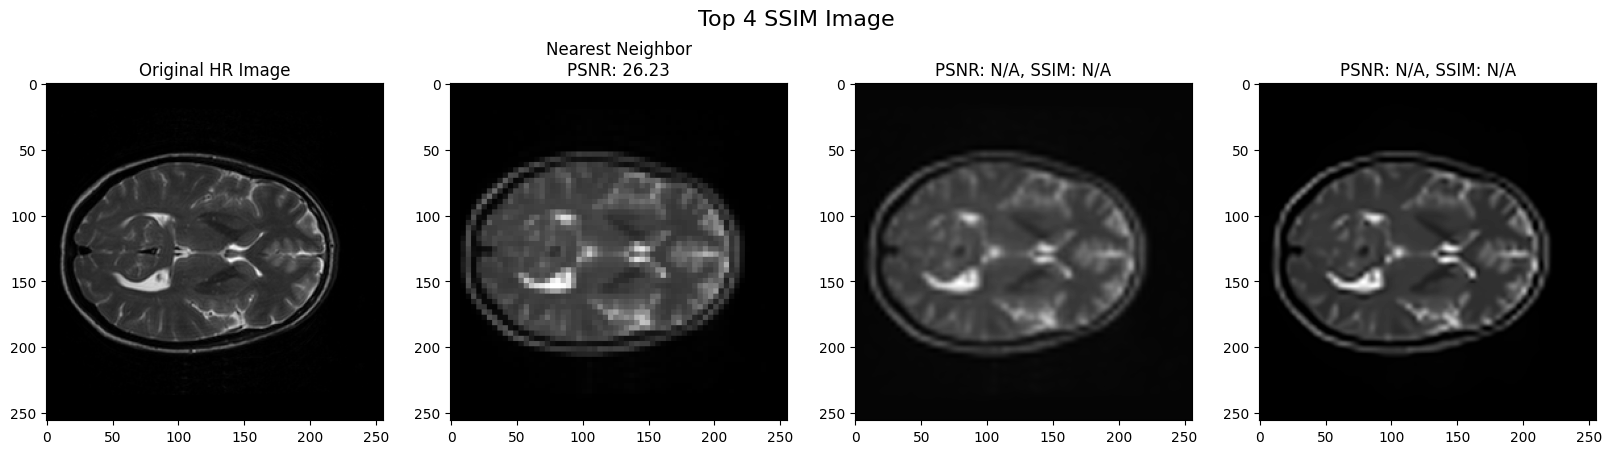

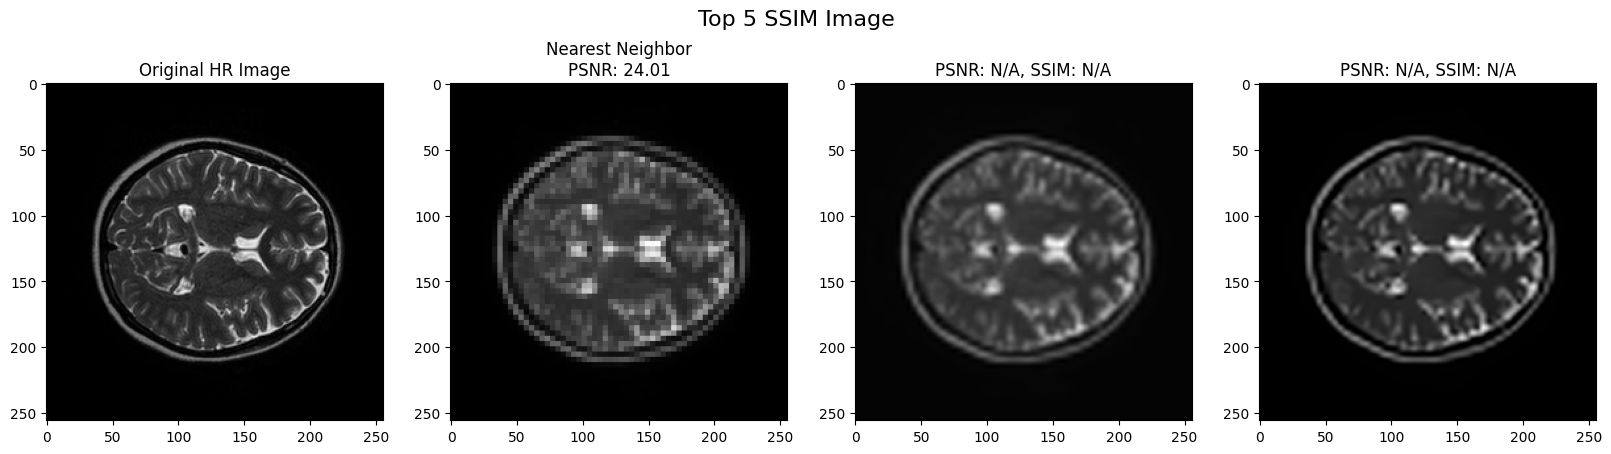

In [ ]:
# Display results
print(f"Average Nearest Neighbor PSNR: {average_nn_psnr:.2f}")
print(f"Average Bicubic PSNR: {average_bicubic_psnr:.2f}")
print(f"Average Super-Resolution PSNR: {average_sr_psnr:.2f}")
print(f"Average Bicubic SSIM: {average_bicubic_ssim:.4f}")
print(f"Average Super-Resolution SSIM: {average_sr_ssim:.4f}")

# Function to display the images
def display_image_comparison(hr_img, nn_img, bicubic_img, sr_img, psnr_sr, ssim_sr, psnr_bicubic, ssim_bicubic, psnr_nn, title):
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 4, 1)
    plt.imshow(hr_img, cmap='gray')
    plt.title('Original HR Image')

    plt.subplot(1, 4, 2)
    plt.imshow(nn_img, cmap='gray')
    plt.title(f'Nearest Neighbor\nPSNR: {psnr_nn:.2f}' if psnr_nn is not None else 'PSNR: N/A')

    plt.subplot(1, 4, 3)
    plt.imshow(bicubic_img, cmap='gray')
    plt.title(f'Bicubic Interpolation\nPSNR: {psnr_bicubic:.2f}' + (f', SSIM: {ssim_bicubic:.4f}' if ssim_bicubic is not None else '') if psnr_bicubic is not None else 'PSNR: N/A, SSIM: N/A')

    plt.subplot(1, 4, 4)
    plt.imshow(sr_img, cmap='gray')
    plt.title(f'Super-Resolution\nPSNR: {psnr_sr:.2f}' + (f', SSIM: {ssim_sr:.4f}' if ssim_sr is not None else '') if psnr_sr is not None else 'PSNR: N/A, SSIM: N/A')

    plt.show()

# Display the top 5 PSNR images
for i, (psnr_sr, hr_img, nn_img, bicubic_img, sr_img_resized, psnr_bicubic, ssim_bicubic, psnr_nn) in enumerate(top_psnr_results):
    display_image_comparison(hr_img, nn_img, bicubic_img, sr_img_resized, psnr_sr, None, psnr_bicubic, None, psnr_nn,
                             f'Top {i+1} PSNR Image')

# Display the top 5 SSIM images
for i, (ssim_sr, hr_img, nn_img, bicubic_img, sr_img_resized, psnr_bicubic, ssim_bicubic, psnr_nn) in enumerate(top_ssim_results):
    display_image_comparison(hr_img, nn_img, bicubic_img, sr_img_resized, None, ssim_sr, None, ssim_bicubic, psnr_nn,
                             f'Top {i+1} SSIM Image')

#### 2x LR Main

Super-resolved image saved at ./results/IXI160-HH-1637-T2_bicubic2x_upscaled_image.png


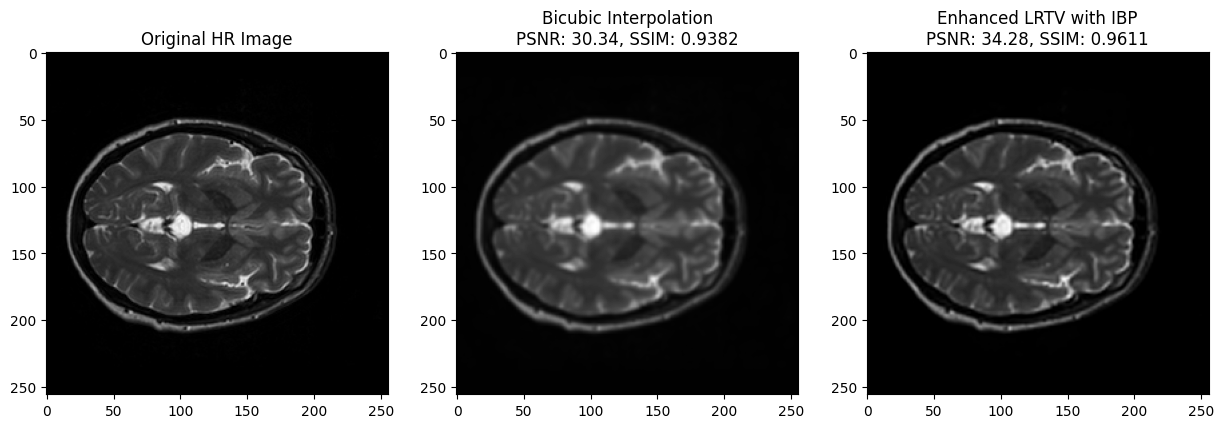

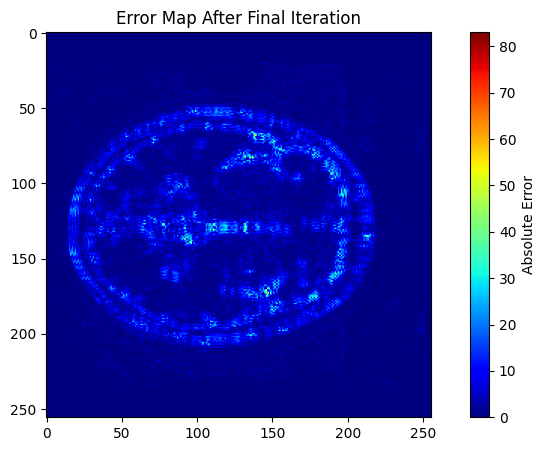

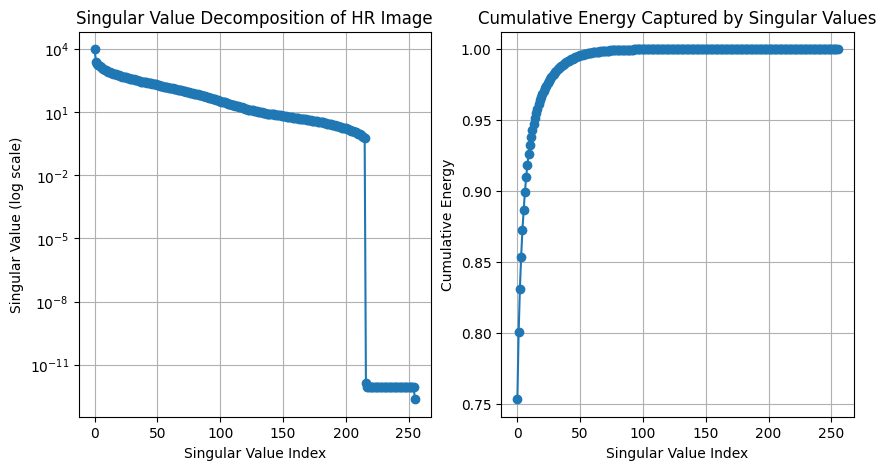

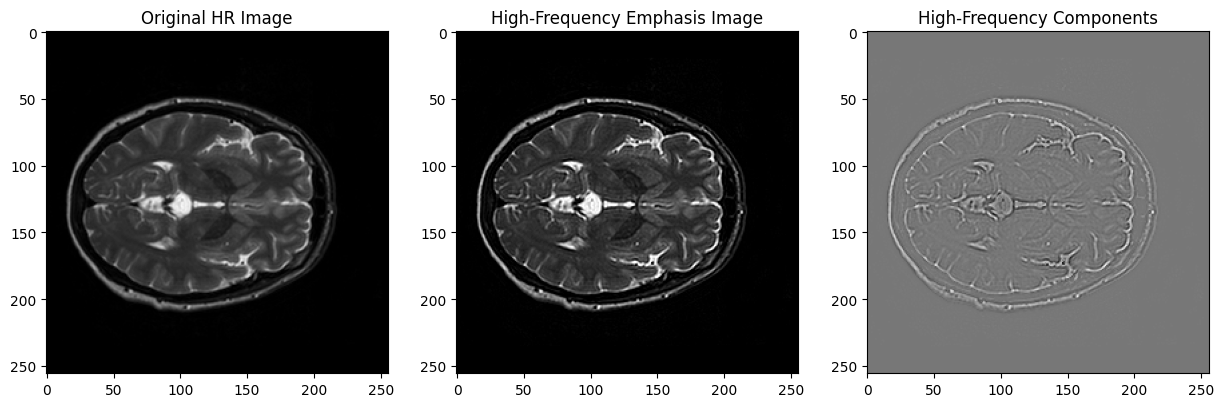

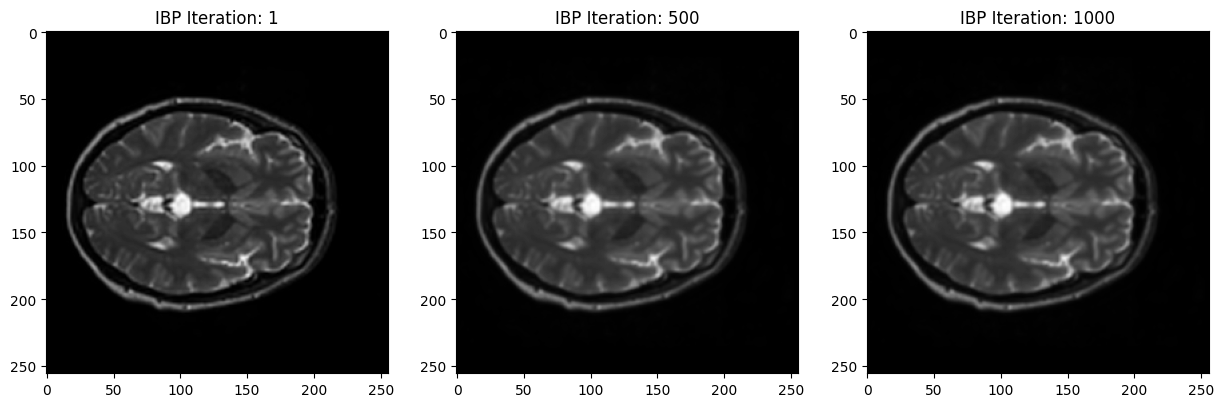

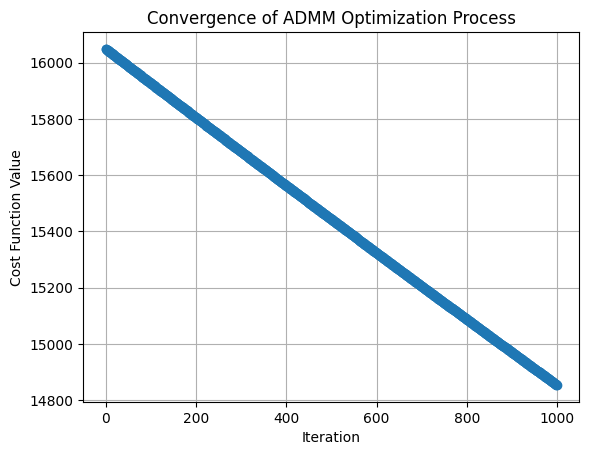

Super-resolved image saved at ./results/IXI160-HH-1637-T2_elrtv_x2.png


In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# Adjustable Parameters
weight_bicubic = 0.1
weight_lanczos = 1 - weight_bicubic
max_iter = 1000
lambda_tv = 3.8182499133012326e-10
lambda_rank = 4.6663781763221334e-05
rho = 4.450473725623792
learning_rate = 2.0988256578008673e-05
l1_weight = 0.16636012148359783
ibp_iter = 1000
projection_alpha = 0.29046887516059244
alpha_high_freq = 1.6
h_nlm = 4.976216207924685
adaptive_noise = True
noise_scale = 0.012106624089355651
anti_aliasing_sigma = 0.2
upscaling_steps = 2
target_scale_factor = 4

# Load and preprocess images
def load_and_preprocess_images(hr_path):
    hr_img = cv2.imread(hr_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    hr_img = cv2.resize(hr_img, (256, 256))  # Ensure HR image is 256x256

    # Generate LR image by blurring and down-sampling the HR image
    blurred_hr = gaussian_filter(hr_img, sigma=1)
    lr_img = cv2.resize(blurred_hr, (128, 128), interpolation=cv2.INTER_AREA)

    return hr_img, lr_img

# Bicubic upsampling (Baseline)
def bicubic_upsample(lr_img, scale_factor=2):
    new_size = (int(lr_img.shape[1] * scale_factor), int(lr_img.shape[0] * scale_factor))
    return cv2.resize(lr_img, new_size, interpolation=cv2.INTER_CUBIC)

# Combined Bicubic and Lanczos upsampling with weights
def combined_upsample(lr_img, scale_factor=2, weight_bicubic=0.3, weight_lanczos=0.7):
    bicubic_img = bicubic_upsample(lr_img, scale_factor)
    lanczos_img = cv2.resize(lr_img, (bicubic_img.shape[1], bicubic_img.shape[0]), interpolation=cv2.INTER_LANCZOS4)
    combined_img = weight_bicubic * bicubic_img + (1 - weight_bicubic) * lanczos_img
    return combined_img

# High-Frequency Emphasis to Preserve Details
def high_frequency_emphasis(img, alpha=0.5874342365346249):
    blurred = gaussian_filter(img, sigma=1)
    high_freq = img - blurred
    enhanced = img + alpha * high_freq
    return np.clip(enhanced, 0, 255)

# Adaptive Non-Local Means Regularization
def adaptive_non_local_means(img, base_h=1.0, adaptive=True, scale=1.0):
    if adaptive:
        sigma_est = np.mean(cv2.fastNlMeansDenoising(img.astype(np.uint8), None, base_h, 7, 21))
        h = max(scale * sigma_est, 0.1)
    else:
        h = base_h
    return cv2.fastNlMeansDenoising(img.astype(np.uint8), None, h, 7, 21).astype(np.float32)

# Singular Value Thresholding (SVT) for Low-Rank Approximation
def svt(X, tau):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S = np.maximum(S - tau, 0)
    return np.dot(U, np.dot(np.diag(S), Vt))

# Anisotropic Total Variation Regularization
def anisotropic_tv(X, lambda_tv):
    grad_x = np.diff(X, axis=1)
    grad_y = np.diff(X, axis=0)
    grad_x = np.pad(grad_x, ((0, 0), (0, 1)), mode='constant')
    grad_y = np.pad(grad_y, ((0, 1), (0, 0)), mode='constant')
    norm_x = np.abs(grad_x)
    norm_y = np.abs(grad_y)
    X = X.copy()
    X[:, :-1] -= lambda_tv * grad_x[:, :-1] / np.maximum(norm_x[:, :-1], 1e-10)
    X[:-1, :] -= lambda_tv * grad_y[:-1, :] / np.maximum(norm_y[:-1, :], 1e-10)
    return X

# Gradient for data fidelity term with hybrid L1 and L2 norms
def compute_hybrid_gradient(hr_img, lr_img, l1_weight=0.5919442711660051):
    blurred_hr = gaussian_filter(hr_img, sigma=1)
    downsampled_hr = cv2.resize(blurred_hr, (lr_img.shape[1], lr_img.shape[0]), interpolation=cv2.INTER_LINEAR)
    diff = downsampled_hr - lr_img
    l1_grad = np.sign(diff)
    l2_grad = diff
    grad = l1_weight * l1_grad + (1 - l1_weight) * l2_grad
    grad = cv2.resize(grad, (hr_img.shape[1], hr_img.shape[0]), interpolation=cv2.INTER_LINEAR)
    return grad

# Iterative Back-Projection (IBP)
def iterative_back_projection(sr_img, lr_img, max_iter=10, projection_alpha=0.2):
    for _ in range(max_iter):
        downsampled_sr = cv2.resize(sr_img, (lr_img.shape[1], lr_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        diff = lr_img - downsampled_sr
        diff_upscaled = cv2.resize(diff, (sr_img.shape[1], sr_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        sr_img += projection_alpha * diff_upscaled
    return sr_img

# Anti-Aliasing filter (Gaussian Blur)
def apply_anti_aliasing(img, sigma=0.5):
    return gaussian_filter(img, sigma=sigma)

# Gradual Upscaling with Anti-Aliasing
def gradual_upscaling(lr_img, target_scale_factor, steps=2, anti_aliasing_sigma=0.5):
    current_img = lr_img
    scale_step = target_scale_factor ** (1.0 / steps)
    for _ in range(steps):
        current_img = apply_anti_aliasing(current_img, sigma=anti_aliasing_sigma)
        current_img = combined_upsample(current_img, scale_factor=scale_step)
    return current_img

# LRTV super-resolution using ADMM with Enhanced Regularization and IBP
def admm_lrtv_with_ibp(lr_img, target_scale_factor, weight_bicubic, weight_lanczos, max_iter, lambda_tv, lambda_rank, rho, learning_rate, l1_weight, ibp_iter, projection_alpha, upscaling_steps=2, anti_aliasing_sigma=0.5, alpha_high_freq=0.2, h_nlm=1, noise_scale=0.05):
    hr_img = gradual_upscaling(lr_img, target_scale_factor=target_scale_factor, steps=upscaling_steps, anti_aliasing_sigma=anti_aliasing_sigma)
    hr_img = cv2.resize(hr_img, (256, 256))  # Ensure final image is 256x256

    M = hr_img.copy()
    Y = np.zeros_like(hr_img)

    cost_values = []
    for i in range(max_iter):
        grad = compute_hybrid_gradient(hr_img, lr_img, l1_weight=l1_weight)
        hr_img -= learning_rate * (grad + rho * (hr_img - M + Y))
        M = svt(hr_img + Y, lambda_rank / rho)
        Y += hr_img - M
        hr_img = anisotropic_tv(hr_img, lambda_tv=lambda_tv)

        # Store cost function value
        cost_value = np.linalg.norm(lr_img - cv2.resize(hr_img, (lr_img.shape[1], lr_img.shape[0]), interpolation=cv2.INTER_LINEAR))**2
        cost_values.append(cost_value)

    hr_img = iterative_back_projection(hr_img, lr_img, max_iter=ibp_iter, projection_alpha=projection_alpha)
    hr_img = high_frequency_emphasis(hr_img, alpha=alpha_high_freq)
    hr_img = adaptive_non_local_means(hr_img, base_h=h_nlm, adaptive=adaptive_noise, scale=noise_scale)

    return cv2.resize(hr_img, (256, 256)), cost_values  # Ensure final image is 256x256

# Singular Value Decomposition (SVD) Plot
def plot_svd(hr_img):
    U, S, Vt = np.linalg.svd(hr_img, full_matrices=False)

    # Plot singular values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(S, 'o-')
    plt.yscale('log')
    plt.title('Singular Value Decomposition of HR Image')
    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value (log scale)')
    plt.grid(True)

    # Plot cumulative sum of singular values
    plt.subplot(1, 2, 2)
    cumulative_energy = np.cumsum(S**2) / np.sum(S**2)
    plt.plot(cumulative_energy, 'o-')
    plt.title('Cumulative Energy Captured by Singular Values')
    plt.xlabel('Singular Value Index')
    plt.ylabel('Cumulative Energy')
    plt.grid(True)
    plt.show()

# High-Frequency Component Emphasis Visualization
def plot_high_frequency_emphasis(hr_img):
    enhanced_img = high_frequency_emphasis(hr_img, alpha=alpha_high_freq)
    high_freq_component = enhanced_img - hr_img

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(hr_img, cmap='gray')
    plt.title('Original HR Image')

    plt.subplot(1, 3, 2)
    plt.imshow(enhanced_img, cmap='gray')
    plt.title('High-Frequency Emphasis Image')

    plt.subplot(1, 3, 3)
    plt.imshow(high_freq_component, cmap='gray')
    plt.title('High-Frequency Components')

    plt.show()

# Iterative Back-Projection (IBP) Process Visualization
def plot_ibp_process(lr_img, sr_img):
    plt.figure(figsize=(15, 5))
    for i, iteration in enumerate([1, ibp_iter//2, ibp_iter]):
        refined_img = iterative_back_projection(sr_img.copy(), lr_img, max_iter=iteration, projection_alpha=projection_alpha)
        plt.subplot(1, 3, i+1)
        plt.imshow(refined_img, cmap='gray')
        plt.title(f'IBP Iteration: {iteration}')

    plt.show()

# Optimization Process Visualization
def plot_optimization_process(cost_values):
    plt.figure()
    plt.plot(cost_values, 'o-')
    plt.title('Convergence of ADMM Optimization Process')
    plt.xlabel('Iteration')
    plt.ylabel('Cost Function Value')
    plt.grid(True)
    plt.show()

# Error Map Visualization
def plot_error_map(hr_img, sr_img):
    error_map = np.abs(hr_img - sr_img)
    plt.figure(figsize=(10, 5))
    plt.imshow(error_map, cmap='jet')
    plt.title('Error Map After Final Iteration')
    plt.colorbar(label='Absolute Error')
    plt.show()

# Save SR image to specified path
def save_sr_image(sr_img, path):
    sr_img_uint8 = np.clip(sr_img, 0, 255).astype(np.uint8)
    cv2.imwrite(path, sr_img_uint8)
    print(f"Super-resolved image saved at {path}")

# Evaluate and display results
def display_results(hr_img, lr_img, sr_img):
    bicubic_img = bicubic_upsample(lr_img, scale_factor=2)

    # Save Bicubic upsampled image to specified path
    bicubic_output_path = './results/IXI160-HH-1637-T2_bicubic2x_upscaled_image.png'
    save_sr_image(bicubic_img, bicubic_output_path)

    sr_img_resized = np.clip(sr_img, 0, 255)
    hr_img = np.clip(hr_img, 0, 255)

    data_range = 255
    psnr_bicubic = psnr(hr_img, bicubic_img, data_range=data_range)
    psnr_sr = psnr(hr_img, sr_img_resized, data_range=data_range)
    ssim_bicubic = ssim(hr_img, bicubic_img, data_range=data_range)
    ssim_sr = ssim(hr_img, sr_img_resized, data_range=data_range)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(hr_img, cmap='gray')
    plt.title('Original HR Image')

    plt.subplot(1, 3, 2)
    plt.imshow(bicubic_img, cmap='gray')
    plt.title(f'Bicubic Interpolation\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}')

    plt.subplot(1, 3, 3)
    plt.imshow(sr_img_resized, cmap='gray')
    plt.title(f'Enhanced LRTV with IBP\nPSNR: {psnr_sr:.2f}, SSIM: {ssim_sr:.4f}')

    plt.show()

# Paths to the images
hr_img_path = './datasets/IXI-T2-Images/test/IXI160-HH-1637-T2.png'

# Load and preprocess images
hr_img, lr_img = load_and_preprocess_images(hr_img_path)

# Perform ADMM LRTV super-resolution with Enhanced Regularization and IBP
sr_img, cost_values = admm_lrtv_with_ibp(
    lr_img,
    target_scale_factor=target_scale_factor,
    weight_bicubic=weight_bicubic,
    weight_lanczos=weight_lanczos,
    max_iter=max_iter,
    lambda_tv=lambda_tv,
    lambda_rank=lambda_rank,
    rho=rho,
    learning_rate=learning_rate,
    l1_weight=l1_weight,
    ibp_iter=ibp_iter,
    projection_alpha=projection_alpha,
    upscaling_steps=upscaling_steps,
    anti_aliasing_sigma=anti_aliasing_sigma,
    alpha_high_freq=alpha_high_freq,
    h_nlm=h_nlm,
    noise_scale=noise_scale
)

# Display and evaluate results
display_results(hr_img, lr_img, sr_img)

# Display Error Map for final iteration
plot_error_map(hr_img, sr_img)

# Additional plots for analysis
plot_svd(hr_img)
plot_high_frequency_emphasis(hr_img)
plot_ibp_process(lr_img, sr_img)
plot_optimization_process(cost_values)

output_path = './results/IXI160-HH-1637-T2_elrtv_x2.png'  # Save path for the SR image
save_sr_image(sr_img, output_path)

#### 2x LR Optuna

In [ ]:
import optuna
from optuna.samplers import TPESampler
import cv2
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import pickle

# Load images and preprocess to generate low-resolution images
def load_images(hr_dir, num_images=25):
    hr_images = []
    lr_images = []

    hr_files = sorted(os.listdir(hr_dir))[:num_images]

    for hr_file in hr_files:
        hr_img = cv2.imread(os.path.join(hr_dir, hr_file), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        hr_img = cv2.resize(hr_img, (256, 256))  # Ensure HR image is 256x256

        # Generate LR image by blurring and down-sampling the HR image
        blurred_hr = gaussian_filter(hr_img, sigma=1)  # Gaussian blur with standard deviation of 1 voxel
        lr_img = cv2.resize(blurred_hr, (128, 128), interpolation=cv2.INTER_AREA)  # Down-sample to 128x128

        hr_images.append(hr_img)
        lr_images.append(lr_img)

    return hr_images, lr_images

# Objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    weight_bicubic = trial.suggest_float('weight_bicubic', 0.0, 1.0)
    weight_lanczos = 1 - weight_bicubic
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    lambda_tv = trial.suggest_float('lambda_tv', 1e-10, 1e-4, log=True)
    lambda_rank = trial.suggest_float('lambda_rank', 1e-10, 1e-4, log=True)
    rho = trial.suggest_float('rho', 0.01, 10.0, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1e-4, log=True)
    l1_weight = trial.suggest_float('l1_weight', 0.0, 1.0)
    ibp_iter = trial.suggest_int('ibp_iter', 10, 500)
    projection_alpha = trial.suggest_float('projection_alpha', 0.1, 1.0)
    alpha_high_freq = trial.suggest_float('alpha_high_freq', 0.0, 2.0)
    h_nlm = trial.suggest_float('h_nlm', 0.1, 5.0)
    noise_scale = trial.suggest_float('noise_scale', 0.01, 0.5)
    anti_aliasing_sigma = trial.suggest_float('anti_aliasing_sigma', 0.1, 5.0)
    upscaling_steps = 2

    # Load the first 25 images
    hr_images, lr_images = load_images('./datasets/IXI-T2-Images/train', num_images=15)

    total_psnr = 0
    total_ssim = 0
    for hr_img, lr_img in zip(hr_images, lr_images):
        # Perform ADMM LRTV super-resolution with the suggested hyperparameters
        sr_img = admm_lrtv_with_ibp(
            lr_img,
            target_scale_factor=2,  # Final scaling factor (128x128 to 256x256)
            weight_bicubic=weight_bicubic,
            weight_lanczos=weight_lanczos,
            max_iter=max_iter,
            lambda_tv=lambda_tv,
            lambda_rank=lambda_rank,
            rho=rho,
            learning_rate=learning_rate,
            l1_weight=l1_weight,
            ibp_iter=ibp_iter,
            projection_alpha=projection_alpha,
            alpha_high_freq=alpha_high_freq,
            h_nlm=h_nlm,
            noise_scale=noise_scale,
            anti_aliasing_sigma=anti_aliasing_sigma,  # Pass the new parameter
            upscaling_steps=upscaling_steps,
        )

        # Calculate PSNR and SSIM for this image
        psnr_value = psnr(hr_img, sr_img, data_range=255)
        ssim_value = ssim(hr_img, sr_img, data_range=255)

        total_psnr += psnr_value
        total_ssim += ssim_value

    # Return the average PSNR and SSIM over all images
    avg_psnr = total_psnr / len(hr_images)
    avg_ssim = total_ssim / len(hr_images)

    # Print PSNR and SSIM for this trial
    print(f'Trial {trial.number}: PSNR={avg_psnr:.4f}, SSIM={avg_ssim:.4f}')

    # Combine PSNR and SSIM into a single metric with 70% weight on SSIM and 30% on PSNR
    combined_metric = 0.3 * avg_psnr + 0.7 * avg_ssim

    return combined_metric

# Function to save the study
def save_study(study, filename):
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

# Function to load the study
def load_study(filename):
    with open(filename, 'rb') as f:
        study = pickle.load(f)
    return study

# Define study filename
study_filename = 'lrtv_2x_optuna_study.pkl'

# Check if a study file exists, if so, load it; otherwise, create a new study
if os.path.exists(study_filename):
    study = load_study(study_filename)
else:
    study = optuna.create_study(direction='maximize', sampler=TPESampler())

# Run Optuna optimization with progress bar
try:
    study.optimize(objective, n_trials=100, callbacks=[lambda study, trial: save_study(study, study_filename)], show_progress_bar=True)
except KeyboardInterrupt:
    print("Optimization interrupted. Study saved.")

# Display the best parameters and the best combined metric value
print("Best Combined Metric (Weighted PSNR + SSIM): ", study.best_value)
print("Best parameters: ", study.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

[W 2024-08-20 04:37:27,316] Trial 247 failed with parameters: {'weight_bicubic': 0.2802127738438424, 'max_iter': 973, 'lambda_tv': 1.2092898518292863e-10, 'lambda_rank': 1.4242839202878372e-08, 'rho': 3.935288033871041, 'learning_rate': 2.1003088388719296e-07, 'l1_weight': 0.21131006480523454, 'ibp_iter': 493, 'projection_alpha': 0.32613177976703395, 'alpha_high_freq': 1.9957787912791254, 'h_nlm': 4.504348343211409, 'noise_scale': 0.051976839600363506, 'anti_aliasing_sigma': 0.45878230227768535} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-5-f34dc6d90b43>", line 55, in objective
    sr_img = admm_lrtv_with_ibp(
  File "<ipython-input-2-caba6652e17a>", line 128, in admm_lrtv_with_ibp
    M = svt(hr_img + Y, lambda_rank / rho)
  File "<ipython-input-2-caba6652e17a>", line 67, in svt
    U, S

#### 2x LR Eval

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize variables to store cumulative PSNR and SSIM values
total_bicubic_psnr = 0
total_sr_psnr = 0
total_bicubic_ssim = 0
total_sr_ssim = 0
total_nn_psnr = 0
num_images = 0

# Variables to store the top 5 PSNR and SSIM results
top_psnr_results = []
top_ssim_results = []

# Get list of images in the directory
image_files = [f for f in os.listdir('./datasets/IXI-T2-Images/test') if f.endswith('.png')]

# Iterate through each image
for image_file in tqdm(image_files, desc="Evaluating images"):
    # Load and preprocess the current image
    hr_img_path = os.path.join('./datasets/IXI-T2-Images/test', image_file)
    hr_img, lr_img = load_and_preprocess_images(hr_img_path)

    # Perform super-resolution
    sr_img = admm_lrtv_with_ibp(
        lr_img,
        target_scale_factor=target_scale_factor,
        weight_bicubic=weight_bicubic,
        weight_lanczos=weight_lanczos,
        max_iter=max_iter,
        lambda_tv=lambda_tv,
        lambda_rank=lambda_rank,
        rho=rho,
        learning_rate=learning_rate,
        l1_weight=l1_weight,
        ibp_iter=ibp_iter,
        projection_alpha=projection_alpha,
        upscaling_steps=upscaling_steps,
        anti_aliasing_sigma=anti_aliasing_sigma,
        alpha_high_freq=alpha_high_freq,
        h_nlm=h_nlm,
        noise_scale=noise_scale
    )

    # Calculate PSNR and SSIM for nearest neighbor upsampling
    nn_img = cv2.resize(lr_img, (256, 256), interpolation=cv2.INTER_NEAREST)
    psnr_nn = psnr(hr_img, nn_img, data_range=255)

    # Calculate PSNR and SSIM for bicubic upsampling
    bicubic_img = bicubic_upsample(lr_img, scale_factor=2)
    psnr_bicubic = psnr(hr_img, bicubic_img, data_range=255)
    ssim_bicubic = ssim(hr_img, bicubic_img, data_range=255)

    # Calculate PSNR and SSIM for super-resolution
    sr_img_resized = np.clip(sr_img, 0, 255)
    psnr_sr = psnr(hr_img, sr_img_resized, data_range=255)
    ssim_sr = ssim(hr_img, sr_img_resized, data_range=255)

    # Accumulate PSNR and SSIM values
    total_nn_psnr += psnr_nn
    total_bicubic_psnr += psnr_bicubic
    total_sr_psnr += psnr_sr
    total_bicubic_ssim += ssim_bicubic
    total_sr_ssim += ssim_sr
    num_images += 1

    # Track the top 5 PSNR and SSIM
    top_psnr_results.append((psnr_sr, hr_img, nn_img, bicubic_img, sr_img_resized, psnr_bicubic, ssim_bicubic, psnr_nn))
    top_ssim_results.append((ssim_sr, hr_img, nn_img, bicubic_img, sr_img_resized, psnr_bicubic, ssim_bicubic, psnr_nn))

    # Sort and keep the top 5
    top_psnr_results = sorted(top_psnr_results, key=lambda x: x[0], reverse=True)[:5]
    top_ssim_results = sorted(top_ssim_results, key=lambda x: x[0], reverse=True)[:5]

# Calculate average PSNR and SSIM
average_nn_psnr = total_nn_psnr / num_images
average_bicubic_psnr = total_bicubic_psnr / num_images
average_sr_psnr = total_sr_psnr / num_images
average_bicubic_ssim = total_bicubic_ssim / num_images
average_sr_ssim = total_sr_ssim / num_images

Evaluating images: 100%|██████████| 70/70 [15:35<00:00, 13.37s/it]


Average Nearest Neighbor PSNR: 27.98
Average Bicubic PSNR: 29.09
Average Super-Resolution PSNR: 32.54
Average Bicubic SSIM: 0.9155
Average Super-Resolution SSIM: 0.9472


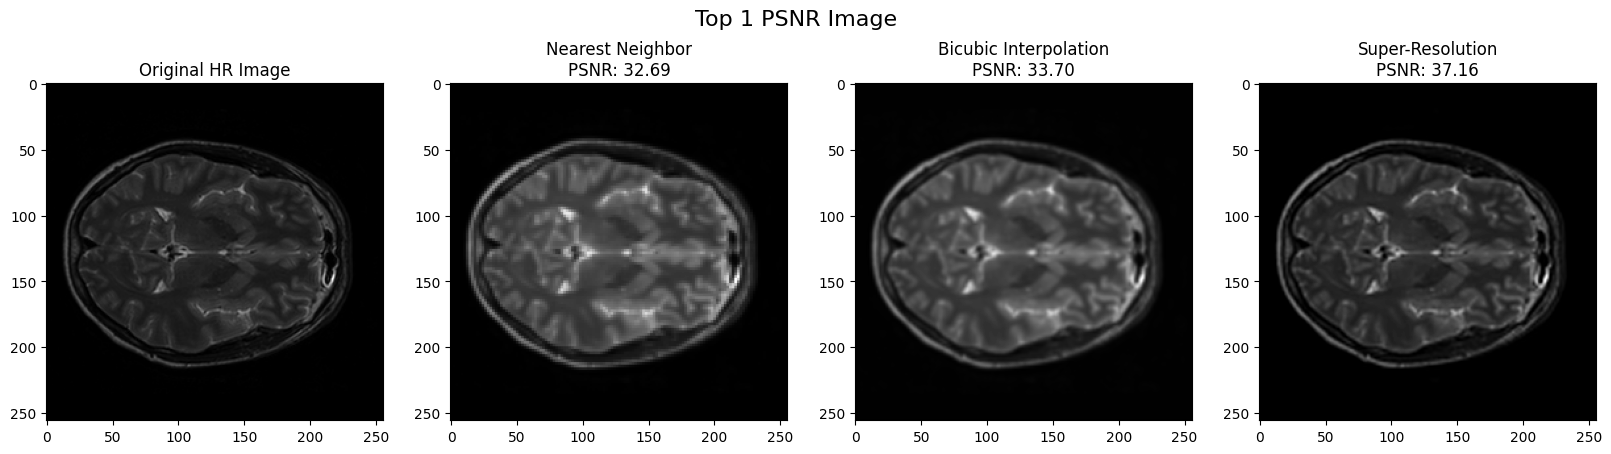

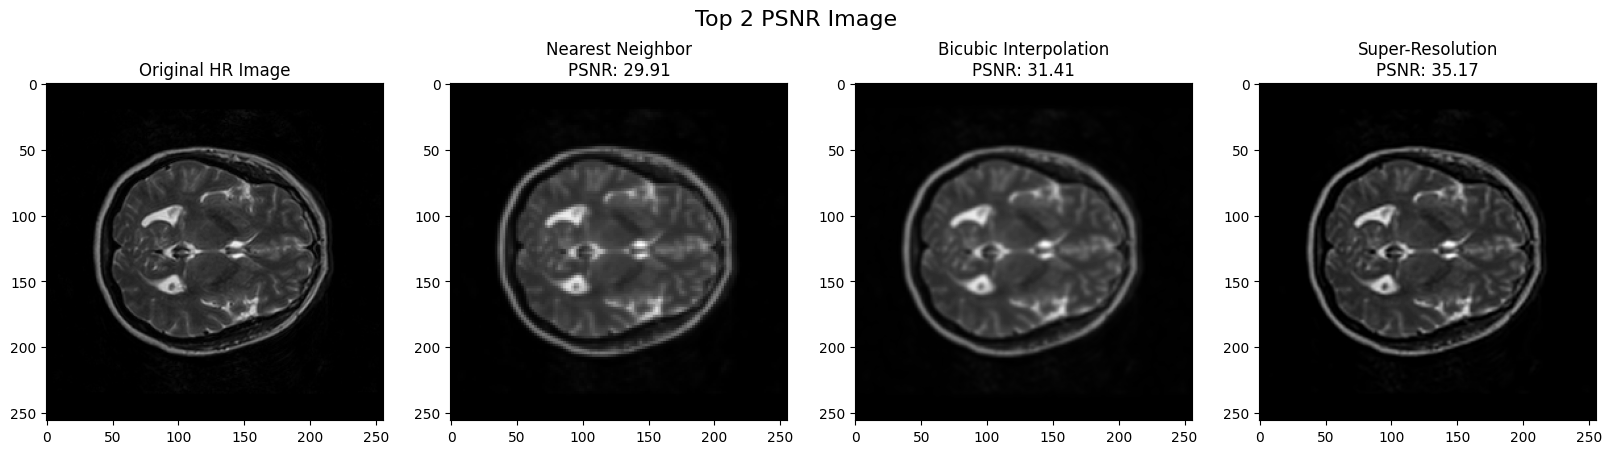

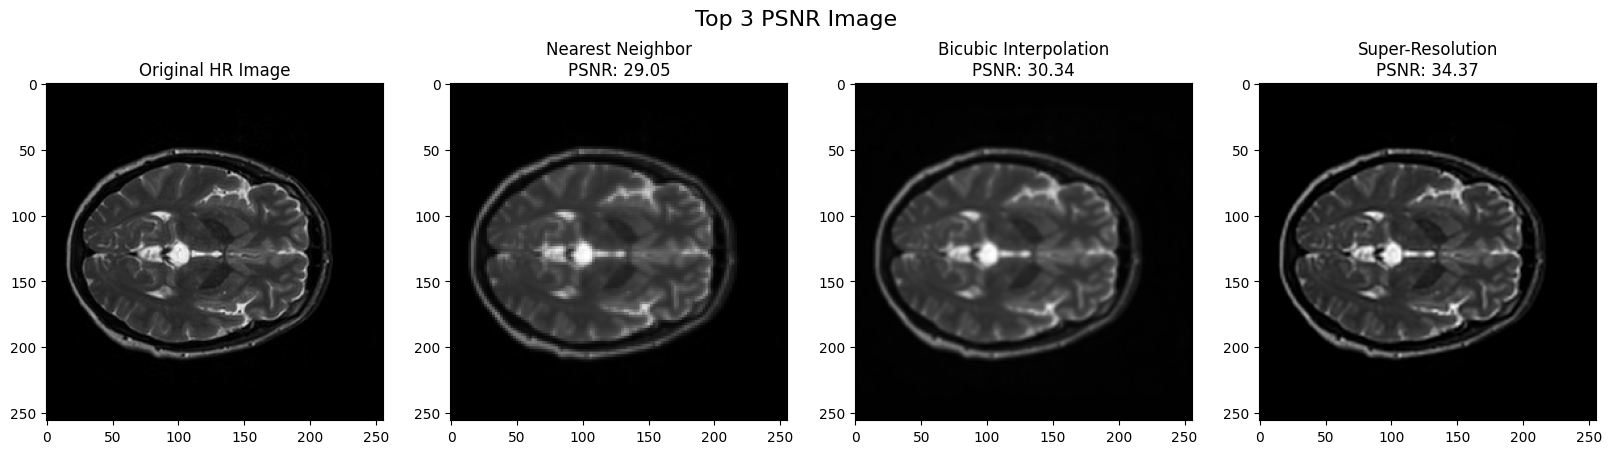

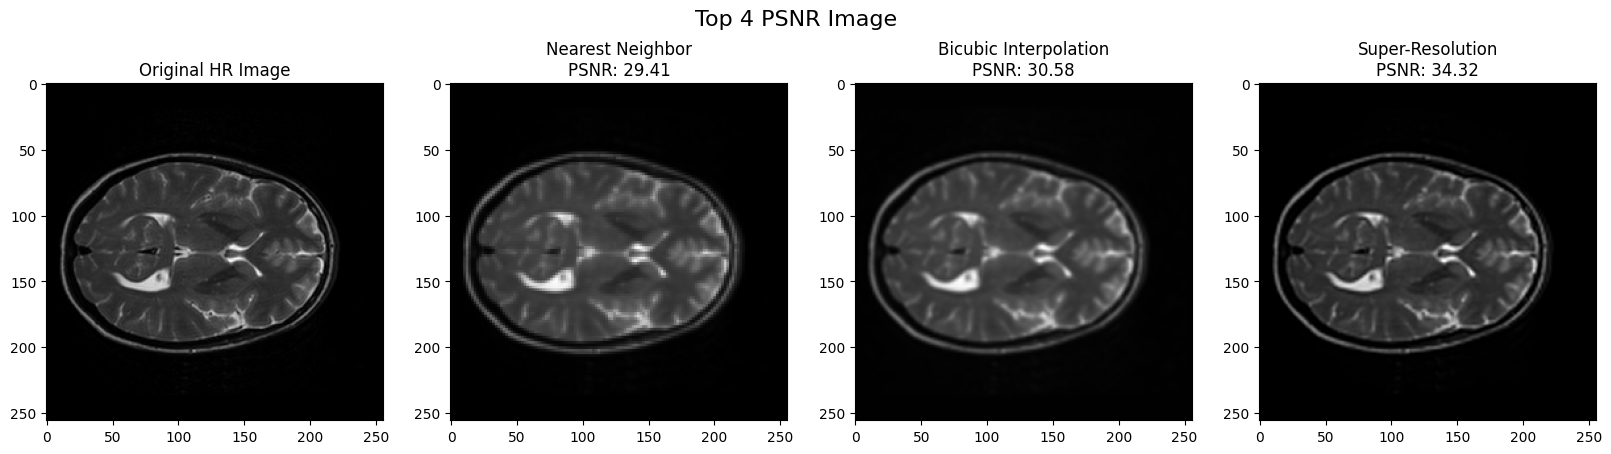

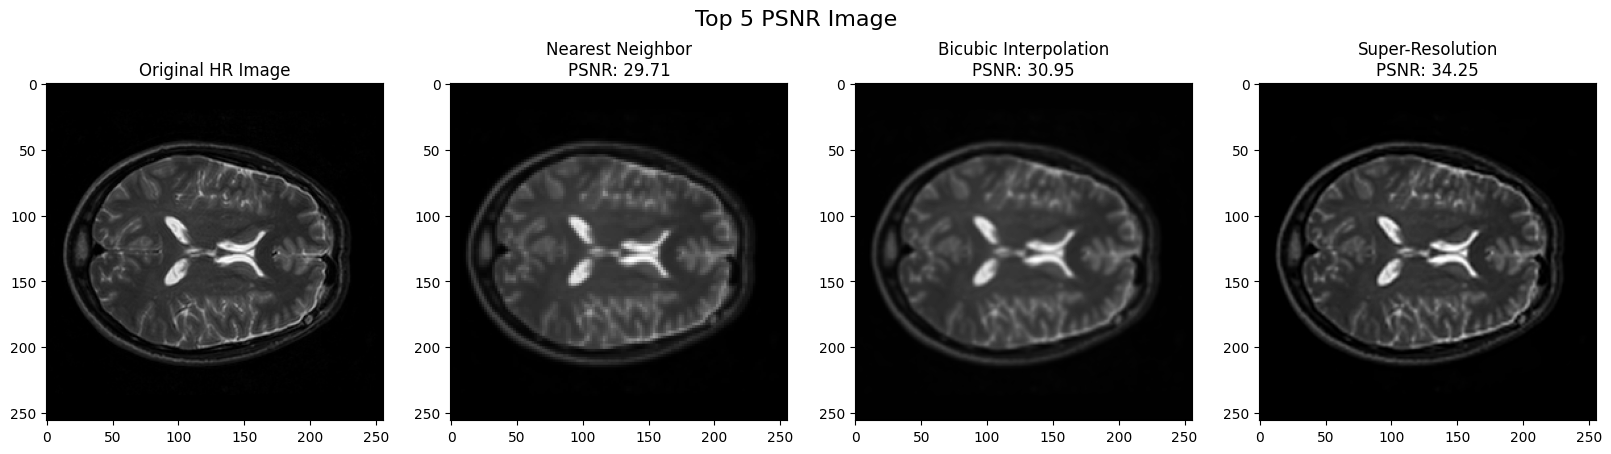

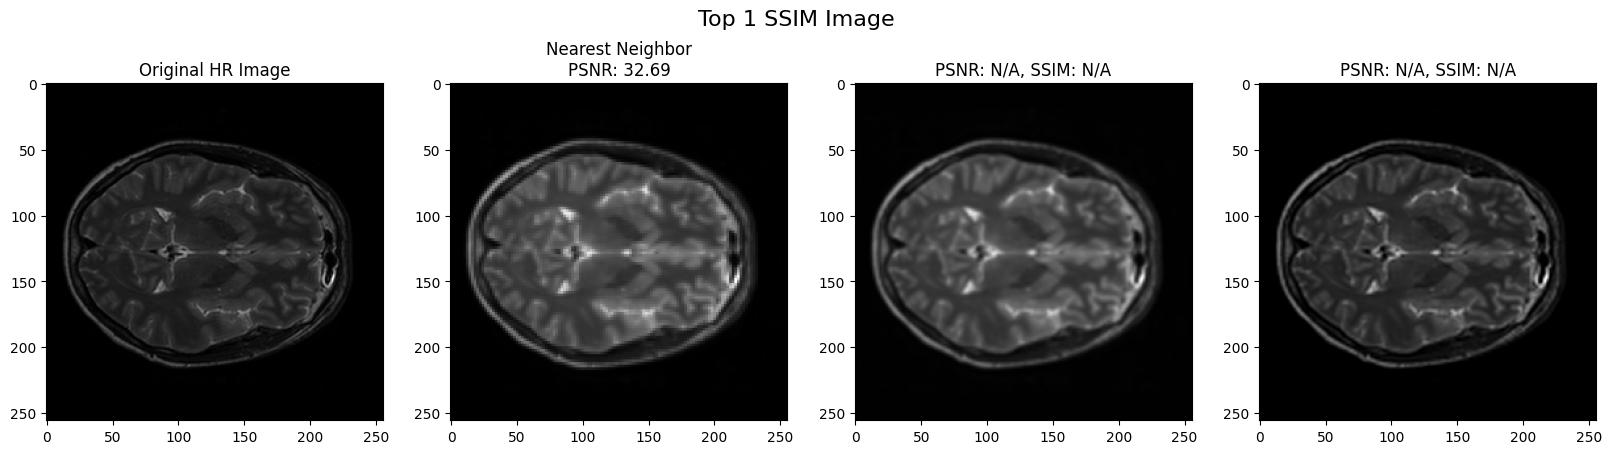

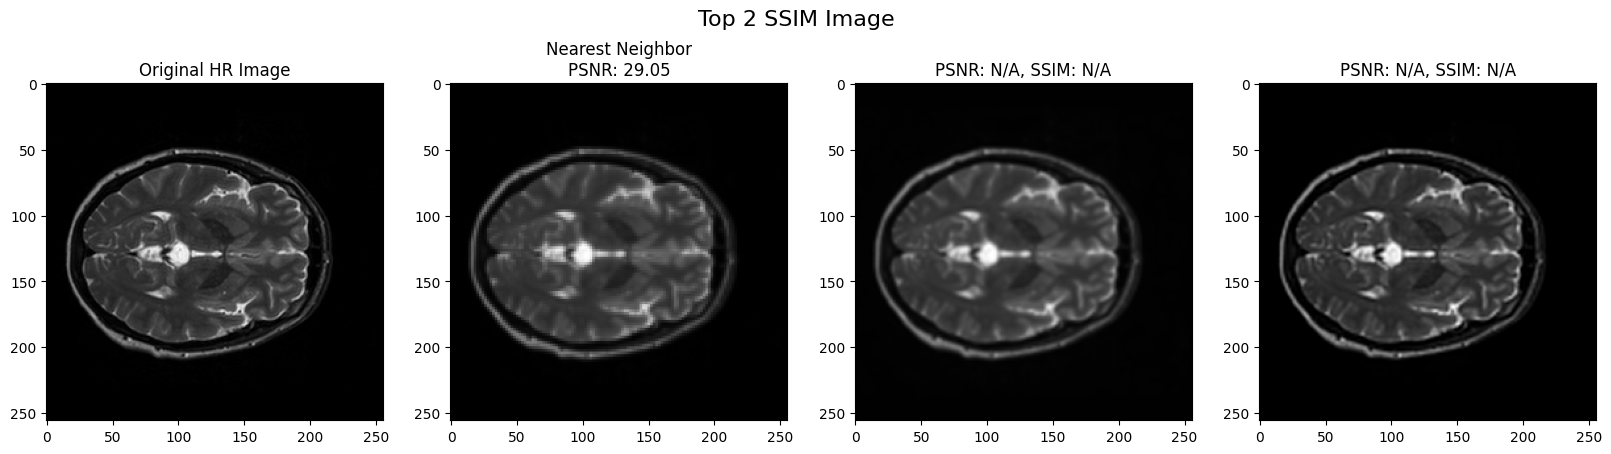

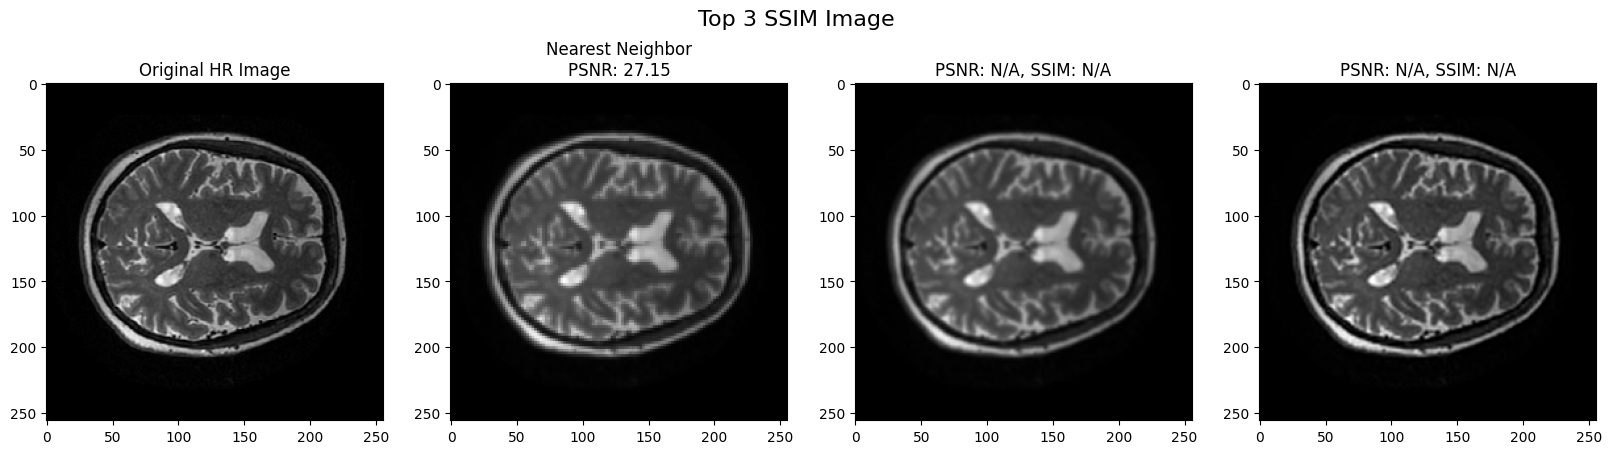

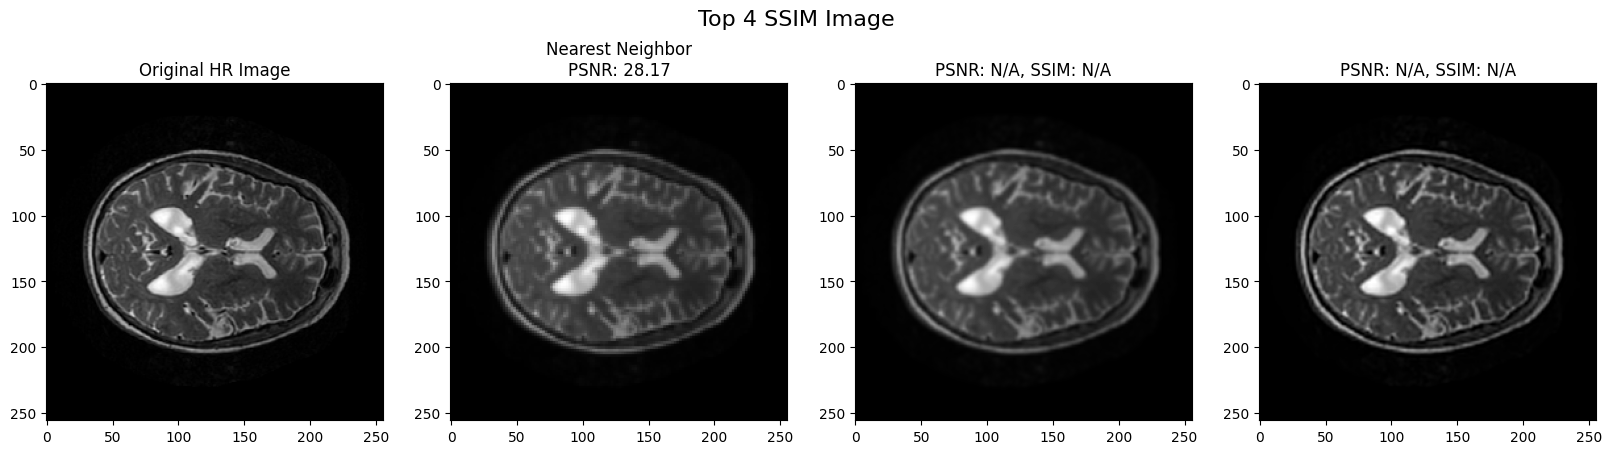

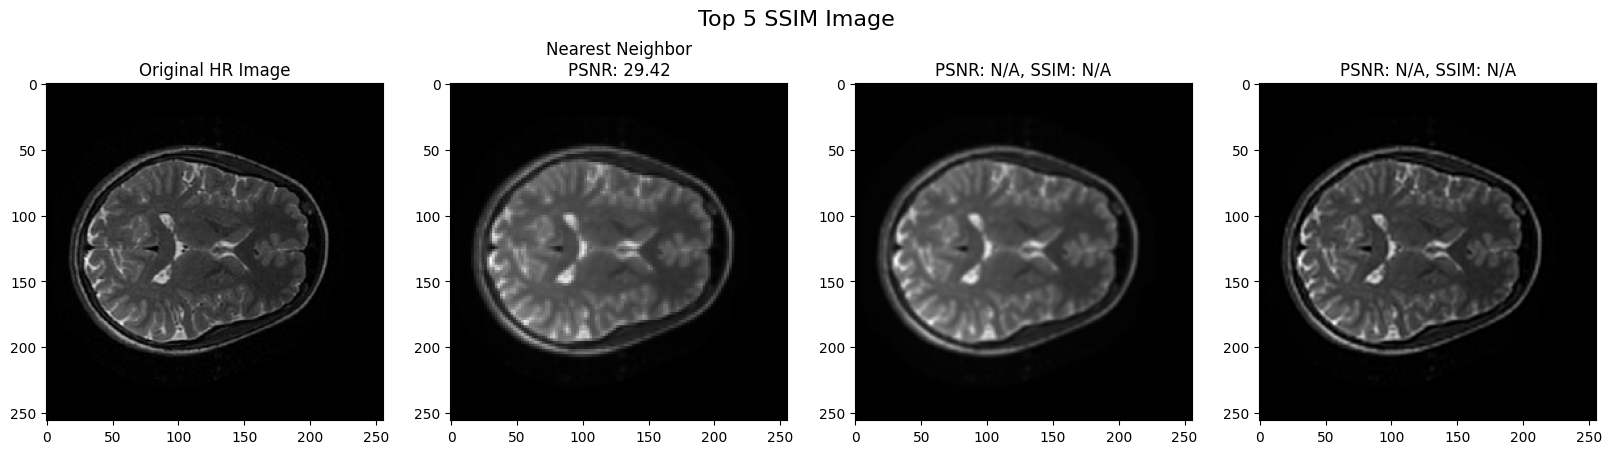

In [ ]:
# Display results
print(f"Average Nearest Neighbor PSNR: {average_nn_psnr:.2f}")
print(f"Average Bicubic PSNR: {average_bicubic_psnr:.2f}")
print(f"Average Super-Resolution PSNR: {average_sr_psnr:.2f}")
print(f"Average Bicubic SSIM: {average_bicubic_ssim:.4f}")
print(f"Average Super-Resolution SSIM: {average_sr_ssim:.4f}")

# Function to display the images
def display_image_comparison(hr_img, nn_img, bicubic_img, sr_img, psnr_sr, ssim_sr, psnr_bicubic, ssim_bicubic, psnr_nn, title):
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 4, 1)
    plt.imshow(hr_img, cmap='gray')
    plt.title('Original HR Image')

    plt.subplot(1, 4, 2)
    plt.imshow(nn_img, cmap='gray')
    plt.title(f'Nearest Neighbor\nPSNR: {psnr_nn:.2f}' if psnr_nn is not None else 'PSNR: N/A')

    plt.subplot(1, 4, 3)
    plt.imshow(bicubic_img, cmap='gray')
    plt.title(f'Bicubic Interpolation\nPSNR: {psnr_bicubic:.2f}' + (f', SSIM: {ssim_bicubic:.4f}' if ssim_bicubic is not None else '') if psnr_bicubic is not None else 'PSNR: N/A, SSIM: N/A')

    plt.subplot(1, 4, 4)
    plt.imshow(sr_img, cmap='gray')
    plt.title(f'Super-Resolution\nPSNR: {psnr_sr:.2f}' + (f', SSIM: {ssim_sr:.4f}' if ssim_sr is not None else '') if psnr_sr is not None else 'PSNR: N/A, SSIM: N/A')

    plt.show()

# Display the top 5 PSNR images
for i, (psnr_sr, hr_img, nn_img, bicubic_img, sr_img_resized, psnr_bicubic, ssim_bicubic, psnr_nn) in enumerate(top_psnr_results):
    display_image_comparison(hr_img, nn_img, bicubic_img, sr_img_resized, psnr_sr, None, psnr_bicubic, None, psnr_nn,
                             f'Top {i+1} PSNR Image')

# Display the top 5 SSIM images
for i, (ssim_sr, hr_img, nn_img, bicubic_img, sr_img_resized, psnr_bicubic, ssim_bicubic, psnr_nn) in enumerate(top_ssim_results):
    display_image_comparison(hr_img, nn_img, bicubic_img, sr_img_resized, None, ssim_sr, None, ssim_bicubic, psnr_nn,
                             f'Top {i+1} SSIM Image')

##  LIIF + EDSR + Attn Implementation

In [2]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.9 MB/s eta 0:00:00


In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 13.7 MB/s eta 0:00:00


In [1]:
import os

os.chdir('/content/drive/MyDrive/Dissertation/modified liif')

In [ ]:
!python train_liif.py --config configs/train-IXI-MRI/train_HIGH_MAED_LIIF-x4_IXI.yaml --name train_HIGH_MAED_LIIF-x4_IXI

config loaded.
./save/train_HIGH_MAED_LIIF-x4_IXI exists, remove? (y/[n]): n
train dataset: size=10040
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  inp: shape=(3, 64, 64)
  coord: shape=(65536, 2)
  cell: shape=(65536, 2)
  gt: shape=(65536, 3)
val dataset: size=960
  inp: shape=(3, 64, 64)
  coord: shape=(65536, 2)
  cell: shape=(65536, 2)
  gt: shape=(65536, 3)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate sch

In [6]:
!python demo.py --input './datasets/IXI-T2-MidSlices/test x4/IXI160-HH-1637-T2.png' --model ./save/train_HIGH_MAED_LIIF-x4_IXI/epoch-best.pth --resolution 256,256 --output IXI160-HH-1637-T2_liifHIGH_x4.png --gpu 0

/content/drive/MyDrive/Dissertation/modified liif/demo.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = models.make(torch.load(args.model)['model'], load_sd=True

In [ ]:
!python test.py --config configs/test/test-div2k-2.yaml --model ./save/train_MAED_LIIF-x4_IXI/epoch-best.pth

val:   0% 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-pa

### Measure PSNR and SSIM for two sets of Images

In [ ]:
import os
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def calculate_metrics(hr_folder, lr_folder):
    psnr_values = []
    ssim_values = []

    for hr_image_name in os.listdir(hr_folder):
        if hr_image_name.endswith('.png') or hr_image_name.endswith('.jpg'):
            hr_image_path = os.path.join(hr_folder, hr_image_name)
            lr_image_path = os.path.join(lr_folder, hr_image_name)

            if os.path.exists(hr_image_path) and os.path.exists(lr_image_path):
                hr_image = cv2.imread(hr_image_path, cv2.IMREAD_GRAYSCALE)
                lr_image = cv2.imread(lr_image_path, cv2.IMREAD_GRAYSCALE)

                lr_image_upscaled = cv2.resize(lr_image, (hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_CUBIC)

                psnr_value = psnr(hr_image, lr_image_upscaled)
                ssim_value = ssim(hr_image, lr_image_upscaled, data_range=lr_image_upscaled.max() - lr_image_upscaled.min())

                psnr_values.append(psnr_value)
                ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Example usage
hr_folder = './datasets/IXI-T2-MidSlices/test'  # Replace with the path to your HR images folder
lr_folder = './results/ood_2x'  # Replace with the path to your LR images folder
avg_psnr, avg_ssim = calculate_metrics(hr_folder, lr_folder)

print(f'Average PSNR: {avg_psnr}')
print(f'Average SSIM: {avg_ssim}')

Average PSNR: 27.671965080809798
Average SSIM: 0.8630884847148252


### Saving bicubic images for comparision

In [ ]:
import cv2
import numpy as np

def bicubic_interpolation(image_path, scale_factor):
    # Read the input image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Get original dimensions
    original_height, original_width = image.shape

    # Calculate new dimensions
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)

    # Perform bicubic interpolation
    scaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    return scaled_image

# Example usage
image_path = './results/ood_2x/IXI053-Guys-0727-T2.png'  # Replace with the path to your image
scale_factor = 2  # Change the scaling factor as needed (e.g., 2 for 2x, 4 for 4x)
scaled_image = bicubic_interpolation(image_path, scale_factor)

# Save or display the scaled image
cv2.imwrite('bicubic_ood_2x.png', scaled_image)  # Save the scaled image
cv2.waitKey(0)
cv2.destroyAllWindows()

### Saving output images with customised settings

In [ ]:
import os
import subprocess

def apply_demo_on_folder(input_folder, output_folder, model_path, resolution, gpu):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_name in os.listdir(input_folder):
        if image_name.endswith('.png') or image_name.endswith('.jpg'):
            input_image_path = os.path.join(input_folder, image_name)
            output_image_path = os.path.join(output_folder, image_name)

            # Construct the command
            command = [
                'python', 'demo.py',
                '--input', input_image_path,
                '--model', model_path,
                '--resolution', resolution,
                '--output', output_image_path,
                '--gpu', str(gpu)
            ]

            # Execute the command
            subprocess.run(command)

# Example usage
input_folder = './datasets/IXI-T2-MidSlices/test x4'  # Path to input folder
output_folder = './results/ood_2x'  # Path to output folder
model_path = './save/train_MAED_LIIF-x2_OOD_IXI/epoch-best.pth'  # Path to the model
resolution = '128,128'  # Desired resolution
gpu = 0  # GPU id

apply_demo_on_folder(input_folder, output_folder, model_path, resolution, gpu)

### Plotting PSNR vs Epochs graphs for different models

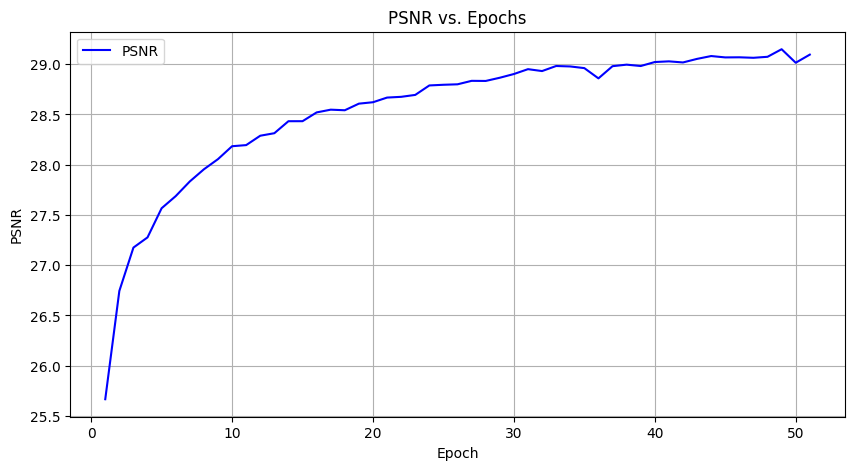

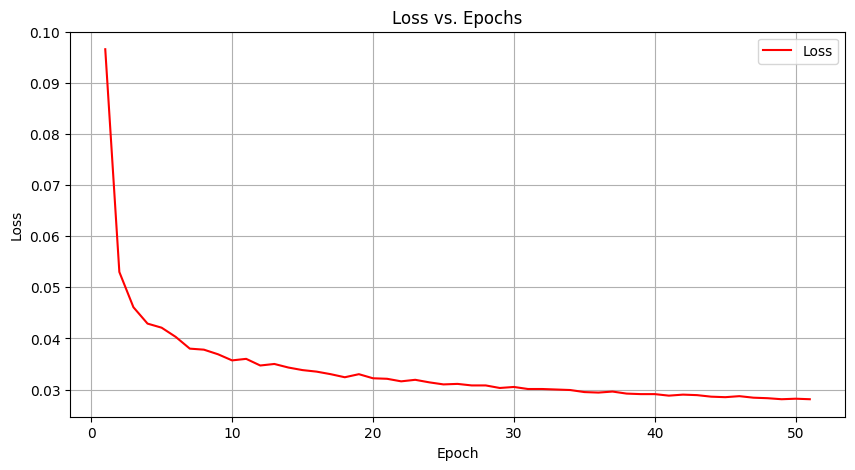

In [ ]:
import re
import matplotlib.pyplot as plt

# Initialize lists to store data
epochs = []
losses = []
psnrs = []

# Define the pattern to extract epoch, loss, and PSNR
epoch_pattern = re.compile(r'epoch (\d+)/\d+, train: loss=([\d\.]+), val: psnr=([\d\.]+)')

# Open and read the file
with open('./save/train_HIGH_MAED_LIIF-x4_IXI/log.txt', 'r') as file:
    for line in file:
        match = epoch_pattern.search(line)
        if match:
            epoch = int(match.group(1))
            loss = float(match.group(2))
            psnr = float(match.group(3))

            # Append data to lists
            epochs.append(epoch)
            losses.append(loss)
            psnrs.append(psnr)

# Plot PSNR over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, psnrs, label='PSNR', color='b')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label='Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()